# Table of Contents
- [ 1 - Introduction](#1)
- [ 2 - Solve Differential Equations with PINNs](#2)
  - [ 2.1 - A Simple ODE](#2.1)
  - [ 2.2 - Heat Equation](#2.2)
  - [ 2.3 - Linear System of PDEs](#2.3)
  - [ 2.4 - Helmholtz Equation](#2.4)
  - [ 2.5 - Hamilton Jacobi Equation](#2.5)
  - [ 2.6 - Kelin - Gordon Equation](#2.6)
- [ 3 - Paramter Identification without Noise](#3)
  - [ 3.1 - A Simple ODE](#3.1)
  - [ 3.2 - Heat Equation](#3.2)
  - [ 3.3 - Linear System of PDEs](#3.3)
  - [ 3.4 - Helmholtz Equation](#3.4)
  - [ 3.5 - Hamilton Jacobi Equation](#3.5)
  - [ 3.6 - Kelin - Gordon Equation](#3.6)
- [ 4 - Paramter Identification with Noise](#4)
  - [ 4.1 - A Simple ODE](#4.1)
  - [ 4.2 - Heat Equation](#4.2)
  - [ 4.3 - Linear System of PDEs](#4.3)
  - [ 4.4 - Helmholtz Equation](#4.4)
  - [ 4.5 - Hamilton Jacobi Equation](#4.5)
  - [ 4.6 - Kelin - Gordon Equation](#4.6)

<a name='1'></a>
## Introduction:


PINNs stand for Physics Informed Neural Networks, and it is used to solve system of (partial or oridnary) differential equations. The core idea is to replace the solution of a differential equation with a neural network, and then use the automatic differentiation of neural networks to define the differential operator. For example, for a 2d problem, one has the following set-up:

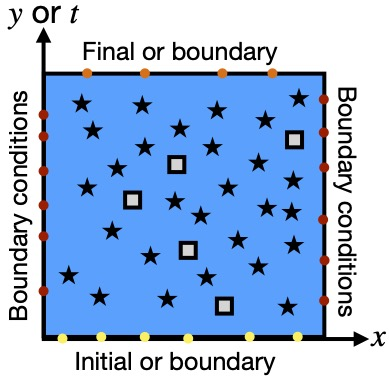



* Circles: Initial/Boundary conditions; Stars: equations; Squares: Data (if available)
* Suppose the equation is given by $\mathcal{N}(u) =0$,  where $\mathcal{N}(u)$ defines the equation, for example, for Burgers equation
$$
\mathcal{N}(u) = u_t + u u_x - \nu u_{xx} =0
$$
* Take the loss function for a given set of weights $\mathbf{w}$  to be
$$
L[\mathbf{w}]  = \mbox{Error in Equations}+ \\
\mbox{Error in Initial conditions} \\
+\mbox{Error in Boundary conditions} \\
+\mbox{Error in Fitting Data}
$$
* In terms of equations, the Loss function is defined as, for example, the total square error (or the mean square error, or mean absolute error, or ...)
$$
L[\mathbf{w}]  =
\frac{1}{2}
\sum_{(x_{\rm int},t_{\rm int})}
\alpha_{\rm eq}
\left\| \mathcal{N}[ u_\mathbf{w}] (x_{\rm int},t_{\rm int}) \right\|^2
\\
+
\frac{1}{2} \sum_{(x_{\rm bnd},t_{\rm bnd})} \alpha_{\rm bnd} \left\|  u_b (x_{\rm bnd},t_{\rm bnd}) -u_\mathbf{w} (x_{\rm bnd},t_{\rm bnd} )\right\|^2
\\
 +
\frac{1}{2} \sum_{(x_{\rm init},t_{\rm init})} \alpha_{\rm init}
\left\|  u_b (x_{\rm init},t_{\rm init}) -u_\mathbf{w} (x_{\rm init},t_{\rm init}) \right\|^2
\\
+
\frac{1}{2} \sum_{(x_{\rm init},t_{\rm init})} \alpha_{\rm data}
\left\|  u_{\rm data} (x_{\rm data},t_{\rm data}) -u_\mathbf{w} (x_{\rm data},t_{\rm data}) \right\|^2
$$
* Find the weights $\mathbf{w}$ minimizing $L$:  $\mathbf{w} = {\rm arg min} L[\mathbf{w}]$  
* If the loss function defined above converges to small number close to zero, one can claim that the function that is defined by the neural network is indeed the solution of the differential equaiton that satisfies the given boundary/initial conditions. This is guaranteed by the Cauchy-Kovalevskaya theorem:


  If $F$ and $f_j$ are analytic functions near 0, then the non-linear Cauchy problem
$$
\partial_t^k h = F(x,t,\partial_t^j\partial_x^{\alpha} h), \quad \text{where} \quad j< k, \quad \text{and} \quad |\alpha| + j \le k,
$$
  with initial conditions:
$$
\partial_t^j h(x,0) = f_j(x), \quad 0\le j < k,
$$
  has a unique analytic solution near 0.

### Advantaiges of PINNs: 
* PINNs do not require a mesh/grid. They learn solutions in the continuous domain, which is helpful for:
    * High-dimensional PDEs: #input nodes = # dimensions,
    * Problems with moving boundaries.
* PINNs can simultaneously handle: forward problems (solve PDEs) and inverse problems (e.g., identify unknown parameters or coefficients in PDEs from data).
* PINNs can easily include data (e.g., boundary conditions, sensor measurements, initial conditions) as part of the loss function. This makes them great for: hybrid modeling (partial physics + partial data) and data assimilation.
* PINNs use automatic differentiation (like in TensorFlow or PyTorch), which allows precise and efficient computation of derivatives needed for the PDE.
* PINNs use ML libraries and can be trained using GPUs and accelerators.
* Once trained, the model generalizes well and can predict solutions at any point in the domain.

In [409]:
#import tensorflow.compat.v1 as tf #'2.16.2'
#tf.enable_eager_execution()
import tensorflow as tf
import deepxde as dde #'1.13.0'

from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt #'3.9.2'
import numpy as np #'1.26.4'
from matplotlib import colormaps as cm
from tqdm import tqdm
import scipy #'1.15.1'

import pandas as pd
import re

from functools import partial

<a name='2'></a>
## Solve Differential Equations with PINNs

### A simple ODE:

Consider the equation $$\frac{dy}{dx} = \cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.


*   Give the approximation to the solution using a PINN for $\omega =2$.
*   Repeat the experiment with $\omega =10$.
* How does the size of $\omega$ affect the training or performance of your PINN?



In [132]:
def exact_solution(x, omega):  # Exact/reference solution
    return (1/omega)*np.sin(omega*x)

Compiling model...
Building feed-forward neural network...
'build' took 1.524721 s

'compile' took 7.305301 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.55e+00, 0.00e+00]    [4.57e+00, 0.00e+00]    []  
1000      [1.61e-03, 5.76e-09]    [1.59e-03, 5.76e-09]    []  
2000      [6.16e-05, 3.57e-12]    [5.71e-05, 3.57e-12]    []  

Best model at step 2000:
  train loss: 6.16e-05
  test loss: 5.71e-05
  test metric: []

'train' took 17.687619 s

Compiling model...
Building feed-forward neural network...
'build' took 0.300893 s

'compile' took 3.069659 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.63e+00, 0.00e+00]    [3.66e+00, 0.00e+00]    []  
1000      [3.70e-01, 6.38e-08]    [3.67e-01, 6.38e-08]    []  
2000      [2.91e-01, 1.27e-08]    [2.88e-01, 1.27e-08]    []  

Best model at step 2000:
  train loss: 2.91e-01
  test loss: 2.88e-01
  test metric: []

'train' took 14.

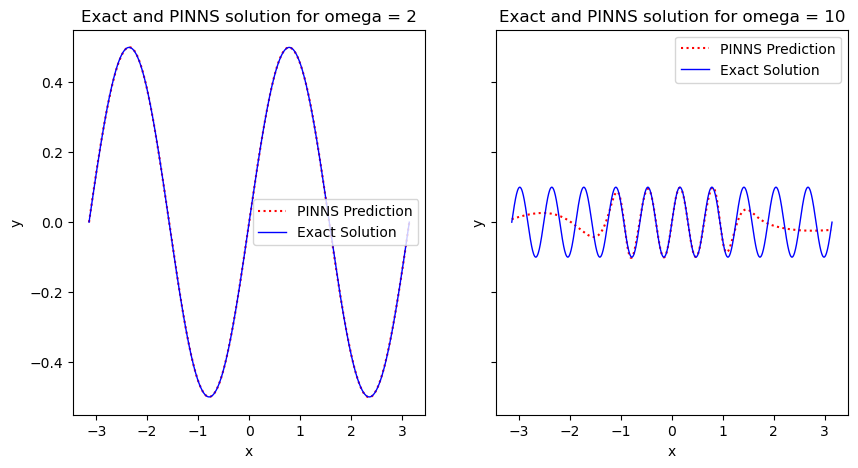

In [134]:
x = np.linspace(-np.pi, np.pi, 1000)
geom = dde.geometry.TimeDomain(x[0], x[-1])

x_begin = 0; y_begin = 0
def boundary_begin(x,_):  # Since the equation is of order one, we only need one boundary/initial condition.
                          # In priciple one coulde apply the initial condion to the solutions by "Hard constrains",
                          # But for this example we decided to use it explicitly as follows:
    return dde.utils.isclose(x[0],x_begin)

def bc_func_begin(x,y,_): 
    
    return y - y_begin

bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)



os = [2,10] #Different values for omega.
for i in [0,1]:
    omega = os[i]
    #ref_solution = partial(exact_solution, omega = omega) # Ref solution
    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,[bc1], 
                        num_domain = 1000,
                        num_boundary = 0, # Note that no boundary points is choosen. This is harmless since the ODE
                                          # is of first order, and we already applied the initial conditions
                        num_test = 200,
                        anchors = None)

    net = dde.nn.FNN([1,30,30,1], 'tanh', 'He uniform')
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.001, metrics = [])
    losshistory, train_state = model.train(iterations = 2000, display_every = 1000)
                
    y_pred = model.predict(x[:, None])
    
 
    
    
    ax[i].plot(x, y_pred, color='r',label='PINNS Prediction', ls=':')
    ax[i].plot(x, exact_solution(x, omega = omega), lw=1, color='b', label='Exact Solution')
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title('Exact and PINNS solution for omega = {}'.format(omega))            
            
    ax[i].legend()

plt.show()            
    


The plots above shows a very close agreement between the exact solutions and PINNS' results, for both parameter values.

### Heat equation


Consider the heat equation $$w_t - aw_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2at + 1\qquad \text{and}\qquad w(1,t)= 2at +2.$$
The exact solution is
$$w(x,t)=x^2 +2at+1.$$


*   Give the approximation to the solution using a PINN for $a =1$.
*   Repeat the experiment with $a =0.01, 10$.



In [5]:
def exact_solution(z, a):
    t = z[:,0:1]
    x = z[:,1:2]
    return x**2 + 2*a*t + 1

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

In [7]:
geom = dde.geometry.Rectangle((0,0), (1, 1))


x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)


def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)




As = [1,0.01,10]
preds = []
for i in [0,1,2]:
    a = As[i]
    
    ref_solution = partial(exact_solution, a = a) # Ref solution
    
    bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 1, boundary_bottom)
    bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 2, boundary_top)
    bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)
    
    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - a * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,[bc_top,bc_bottom,bc_ic],
                        solution = ref_solution,
                        num_domain = 1000,
                        num_boundary = 6,
                        num_test =50
                       )
    
    net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'He uniform')
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.001, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, display_every = 1000)
    
    w_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x))
    
    preds.append(w_pred)
    
    


Compiling model...
Building feed-forward neural network...
'build' took 0.129795 s

'compile' took 1.093993 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.26e+02, 2.75e+01, 5.05e+00, 7.48e+00]    [1.11e+02, 2.75e+01, 5.05e+00, 7.48e+00]    []  
1000      [1.77e-03, 2.28e-04, 1.72e-04, 3.46e-07]    [9.93e-04, 2.28e-04, 1.72e-04, 3.46e-07]    []  

Best model at step 1000:
  train loss: 2.17e-03
  test loss: 1.39e-03
  test metric: []

'train' took 18.929338 s

Compiling model...
Building feed-forward neural network...
'build' took 0.096557 s

'compile' took 0.605729 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.65e-01, 1.39e+01, 2.21e+00, 7.48e+00]    [3.93e-01, 1.39e+01, 2.21e+00, 7.48e+00]    []  
1000      [3.52e-04, 1.42e-05, 1.02e-05, 4.52e-07]    [1.41e-04, 1.42e-05, 1.02e-05, 4.52e-07] 

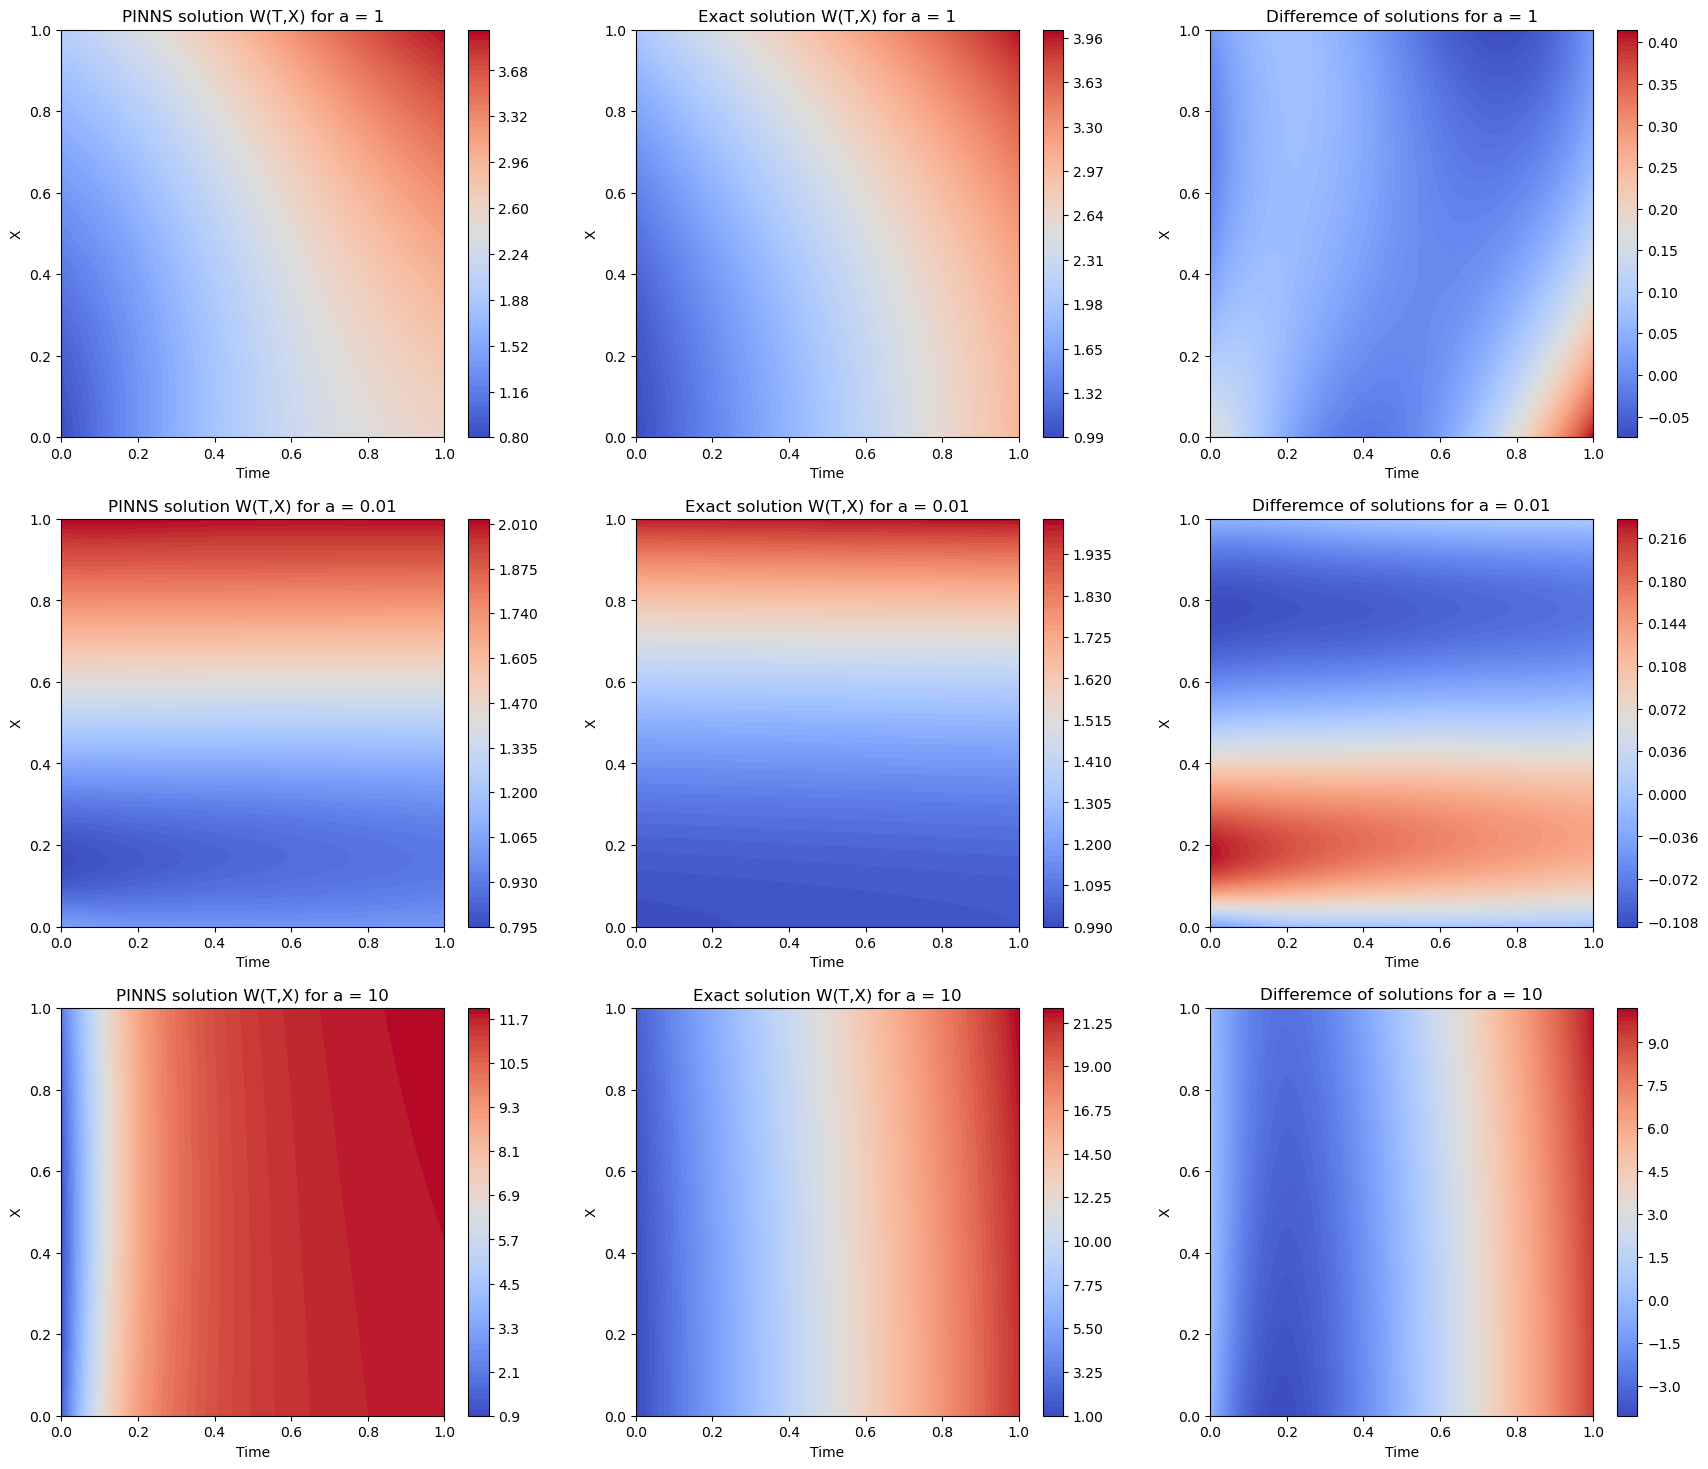

In [9]:
def exact_solution(t,x, a):

    return x**2 + 2*a*t + 1

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

fig, ax  = plt.subplots(3,3 , figsize = (21,18))

for i in range(len(As)):
    a = As[i]
    w_pred = preds [i]
    
   

    im = ax[i,0].contourf(T, X, w_pred, cmap="coolwarm", levels=100)
    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('X')
    ax[i,0].set_title('PINNS solution W(T,X) for a = {}'.format(a))  
    fig.colorbar(im, ax = ax[i,0])

    im = ax[i,1].contourf(T, X, exact_solution(T,X,a), cmap="coolwarm", levels=100)
    ax[i,1].set_xlabel('Time')
    ax[i,1].set_ylabel('X')
    ax[i,1].set_title('Exact solution W(T,X) for a = {}'.format(a))
    fig.colorbar(im, ax = ax[i,1])

    im = ax[i,2].contourf(T, X, exact_solution(T,X,a) - w_pred, cmap="coolwarm", levels=100)
    ax[i,2].set_xlabel('Time')
    ax[i,2].set_ylabel('X')
    ax[i,2].set_title('Differemce of solutions for a = {}'.format(a))
    fig.colorbar(im, ax = ax[i,2])
    
plt.show()

Overall it seems the PINNs solution is pretty close to the actual solution. However, the value of the test/train loss for $a=10$ is 4 orders higher than the corresponding numbers for $a=1, 0.1$. This is also clear from the graphs that the final case ($a=10$) is not as precise as the others.

### A system of linear PDEs


Consider the system \begin{array}{l}
v_t - a v_{xx} = -v ,\\
w_t - a w_{xx} =  v - 2 w.
\end{array}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(2at+1\right)e^{-t}, \\
v(1,t) = \left(2at+2\right)e^{-t},\\
w(0,t) = \left(2at+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(2at+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}
The exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + 2at + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + 2at + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

In [32]:
a = 2
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + 2*a*T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + 2*a*T + 1)*(np.exp(-T) - np.exp(-2*T))
def sys_sol(Z):
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    return np.stack([v.flatten(), w.flatten()], 1)

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

In [34]:
geom = dde.geometry.Rectangle((0,0), (1, 1))

x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)


bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w]


def HEAT2_deepxde(z,y):
    
    v = y[:,0:1]
    w = y[:,1:2]
    
    dw_dt = dde.grad.jacobian(w,z,0,0)
    dw_dx = dde.grad.jacobian(w,z,0,1)
    d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
    dv_dt = dde.grad.jacobian(v,z,0,0)
    dv_dx = dde.grad.jacobian(v,z,0,1)
    d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
    return [
        dv_dt - a * d2v_dx2 + v,
        dw_dt - a * d2w_dx2 - v + 2*w
    ]

def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    v = q[:, 0:1]
    w = q[:, 1:2]
    t = z[:, 0:1]
    x = z[:, 1:2]
    return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


data = dde.data.PDE(geom, HEAT2_deepxde,bcs,
                        solution = sys_sol,
                        num_domain = 1000,
                        num_boundary = 6,
                        num_test=100)
    
net = dde.nn.FNN([2] + [60]*4 + [2], 'tanh', 'He uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.001, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 1000)
    
Z_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x),2)




Compiling model...
Building feed-forward neural network...
'build' took 0.137353 s

'compile' took 3.434075 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.75e+01, 2.23e+01, 9.58e-02, 3.98e+00, 6.18e-01, 5.24e-01]    [3.02e+01, 2.44e+01, 9.58e-02, 3.98e+00, 6.18e-01, 5.24e-01]    []  
1000      [1.36e-03, 9.96e-04, 2.09e-04, 3.66e-04, 1.77e-05, 6.73e-05]    [7.25e-04, 6.33e-04, 2.09e-04, 3.66e-04, 1.77e-05, 6.73e-05]    []  
2000      [3.38e-04, 3.75e-04, 1.79e-05, 1.08e-05, 2.21e-06, 4.39e-06]    [2.08e-04, 2.45e-04, 1.79e-05, 1.08e-05, 2.21e-06, 4.39e-06]    []  

Best model at step 2000:
  train loss: 7.48e-04
  test loss: 4.88e-04
  test metric: []

'train' took 62.812171 s



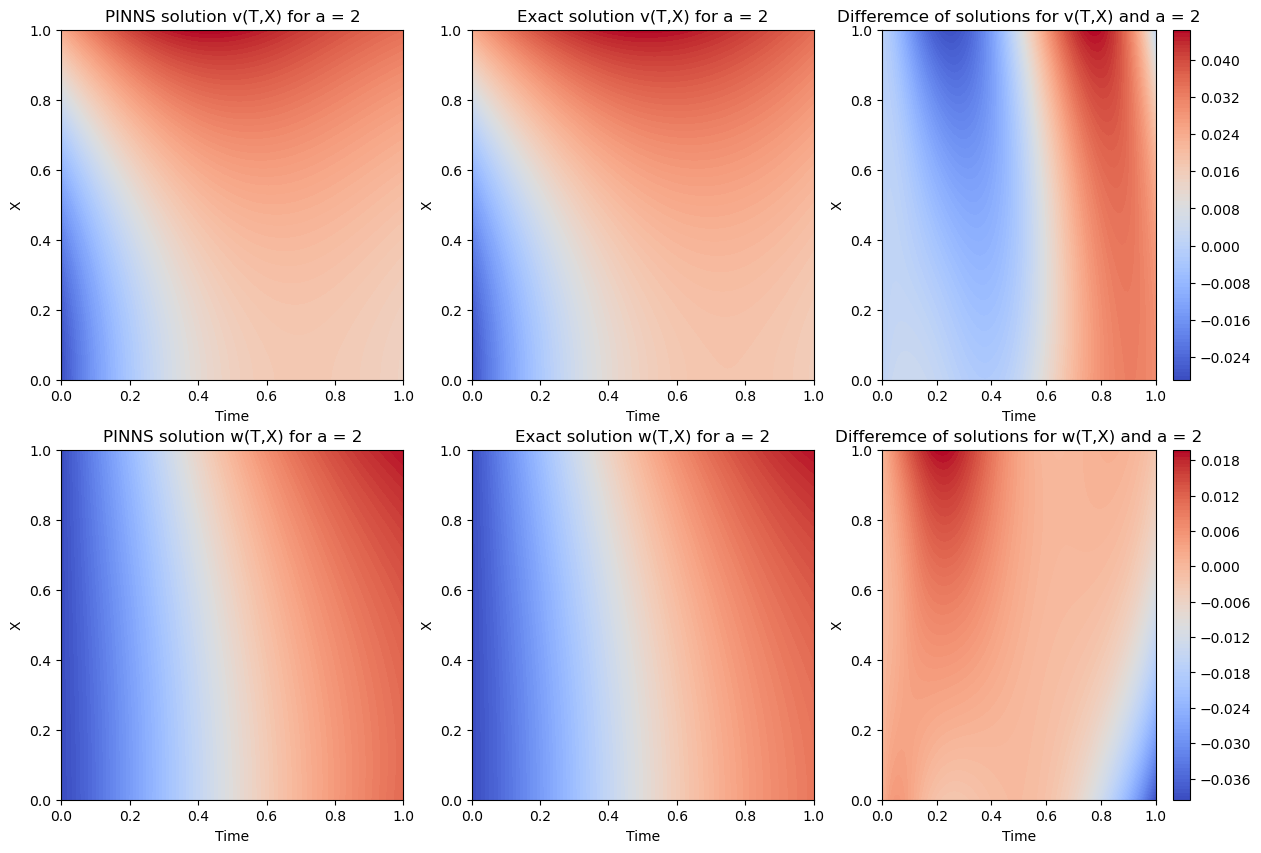

In [35]:
plt.figure(figsize=(15, 10))
    
plt.subplot(2,3,1)
plt.contourf(T, X, Z_pred[:,:,0], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('PINNS solution v(T,X) for a = {}'.format(a))  

plt.subplot(2,3,2)
plt.contourf(T, X, v_sol(X,T), cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Exact solution v(T,X) for a = {}'.format(a)) 

plt.subplot(2,3,3)
plt.contourf(T, X, v_sol(X,T) - Z_pred[:,:,0], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Differemce of solutions for v(T,X) and a = {}'.format(a))
plt.colorbar()



plt.subplot(2,3,4)
plt.contourf(T, X, Z_pred[:,:,1], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('PINNS solution w(T,X) for a = {}'.format(a))  

plt.subplot(2,3,5)
plt.contourf(T, X, w_sol(X,T), cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Exact solution w(T,X) for a = {}'.format(a)) 

plt.subplot(2,3,6)
plt.contourf(T, X, w_sol(X,T) - Z_pred[:,:,1], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Differemce of solutions for w(T,X) and a = {}'.format(a))
plt.colorbar()
    
plt.show()

Again the PINNS solution for both components (v,w) is very close to the actual solution. Specially the train/test loss is of order $10^{-4}$. We study the accuracy more precisely bellow:

### Helmholtz equation

Consider the Dirichlet problem $$\nabla^2 E(x,y) + \frac{\pi^2}{2}E(x,y) = 0,\qquad x,y \in \Omega =[-2, 2]^2,$$
subject to boundary conditions
$$E(-2,y)=E(2,y)=-\cos\left(\frac{\pi}{2} y\right)-\sin\left(\frac{\pi}{2} y\right),$$
$$E(x,-2)=E(x, 2)=-\cos\left(\frac{\pi}{2} x\right)-\sin\left(\frac{\pi}{2} x\right).$$

We want to find the following solution using a neural network $$ E^*(x,y) = \cos\frac{\pi\left(x- y\right)}{2}+ \sin\frac{\pi\left(x + y\right)}{2}.$$
There are many other solutions to the Dirichlet problem above, for example $(x,y)\mapsto \sin\left(\frac{\pi}{2} x\right)\sin\left(\frac{\pi}{2} y\right)$ is a solution. So to learn $E^*$ we need to provide the neural network with additional training points. We'll provide you with a function that generates training points from the true solution.

In [32]:
def helm_sol(X, Y):
    return np.cos((X-Y)*np.pi/2)+np.sin((X+Y)*np.pi/2)

x_min = -2; x_max = 2
y_min = -2; y_max = 2
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)

def helm_data(num_pts=10):
    X = np.random.uniform(x_min, x_max, num_pts)
    Y = np.random.uniform(y_min, y_max, num_pts)
    Z = np.stack([X, Y], 1)
    return Z, helm_sol(X, Y).reshape(num_pts, 1)

# PINNS Solutions

def exact_solution(z):
    x = z[:,0:1]
    y = z[:,1:2]
    
    E = np.cos((x-y)*np.pi/2) + np.sin((x+y)*np.pi/2)
    
    return E


geom = dde.geometry.Rectangle((x_min,y_min), (x_max,y_max))

def boundary_xmin(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_xmax(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def boundary_ymin(z,on_boundary):  
    return dde.utils.isclose(z[1],y_min)

def boundary_ymax(z,on_boundary):  
    return dde.utils.isclose(z[1],y_max)

bc_min_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmin, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmax, component = 0)

bc_min_y = dde.icbc.DirichletBC (geom, lambda z:  -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymin, component = 0)
bc_max_y = dde.icbc.DirichletBC (geom, lambda z:  -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymax, component = 0)

points, Es = helm_data(num_pts = 10)
observe = dde.icbc.PointSetBC(points, Es )

bcs = [bc_min_x, bc_max_x,bc_min_y, bc_max_y, observe]

def Helmholtz_deepxde(z,h):
    
    E = h[:, 0:1]
    
    dE_dx = dde.grad.jacobian(E,z,0,0)
    d2E_dx2 = dde.grad.jacobian(dE_dx,z,0,0)
    dE_dy = dde.grad.jacobian(E,z,0,1)
    d2E_dy2 = dde.grad.jacobian(dE_dy,z,0,1)
    
    
    return d2E_dx2 + d2E_dy2 + (2*(np.pi/2)**2) * E

data = dde.data.PDE(geom, Helmholtz_deepxde,bcs, 
                        num_domain = 1000,
                        solution = exact_solution,
                        num_boundary = 100,
                        num_test = 50,
                    anchors = points
                       )

net = dde.nn.FNN([2] + [60]*7 + [1], 'sin', 'Glorot normal')
model = dde.Model(data, net)
model.compile('adam', lr = 0.01, metrics = [])
losshistory, train_state = model.train(iterations = 1000, display_every = 1000)
    
Z_pred = model.predict(np.stack((X.ravel(), Y.ravel()), axis=-1)).reshape(len(x), len(y), 1)


Compiling model...
Building feed-forward neural network...
'build' took 0.253426 s

'compile' took 8.642947 s

Training model...

0         [1.30e+00, 1.28e+00, 1.22e+00, 8.90e-01, 8.14e-01, 1.55e+00]    [1.12e+00, 1.28e+00, 1.22e+00, 8.90e-01, 8.14e-01, 1.55e+00]    []  
1000      [6.67e-03, 8.82e-04, 6.24e-04, 1.03e-03, 4.03e-04, 4.26e-04]    [6.34e-03, 8.82e-04, 6.24e-04, 1.03e-03, 4.03e-04, 4.26e-04]    []  

Best model at step 1000:
  train loss: 1.00e-02
  test loss: 9.70e-03
  test metric: []

'train' took 92.092183 s



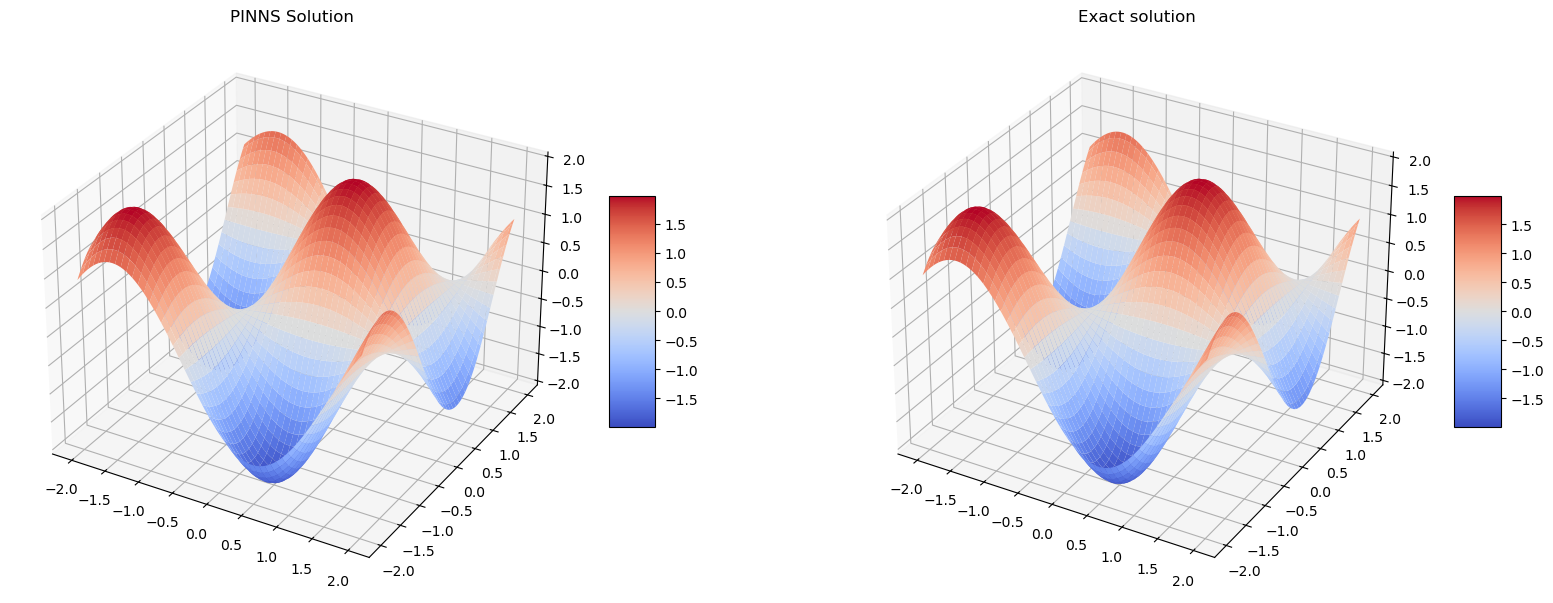

In [34]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = helm_sol(X,Y)


fig, ax = plt.subplots(1,2 , subplot_kw={"projection": "3d"}, figsize = (20,10))

surf_PINNS = ax[0].plot_surface(X, Y, Z_pred[:,:,0], cmap="coolwarm")
fig.colorbar(surf_PINNS, shrink=0.3, aspect=5)
ax[0].set_title('PINNS Solution')

surf_EXACT = ax[1].plot_surface(X, Y, Z, cmap='coolwarm')
fig.colorbar(surf_EXACT, shrink=0.3, aspect=5)
ax[1].set_title('Exact solution')

plt.show()

### Hamilton-Jacobi equation

Consider the Hamilton-Jacobi equation \begin{array}{l}\varphi_t+\sin(x)\varphi_x = 0, \;  x\in[0, 2\pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(0, t) = \varphi(2\pi, t)= 0.  \end{array}

The exact solution is
$$
\varphi(x,t) = \sin\left(2\arctan\left(e^{-t}\tan\left(\frac{x}{2} \right)\right)\right)
$$

In [20]:
# PINNS Solution:

t_max = 1; t_min = 0
x_max = 2*np.pi; x_min = 0
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)


geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)
bcs = [bc_min_x, bc_max_x]

def HJ_deepxde(z,y):
    
    phi = y[:, 0:1]
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    dphi_dt = dde.grad.jacobian(phi,z,0,1)
    dphi_dx = dde.grad.jacobian(phi,z,0,0)
    
    
    return dphi_dt  + tf.sin(x) * dphi_dx

def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    phi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return phi * tf.tanh(t) + tf.sin(x)

data = dde.data.PDE(geom, HJ_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 15,
                        num_test = 100
                       )
                       
net = dde.nn.FNN([2] + [30]*4 + [1], 'tanh', 'He normal')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)

Compiling model...
Building feed-forward neural network...
'build' took 0.174807 s

'compile' took 0.596145 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.10e-01, 8.82e-03, 7.36e-02]    [3.34e-01, 8.82e-03, 7.36e-02]    []  
2000      [9.44e-05, 2.97e-05, 5.48e-05]    [8.15e-05, 2.97e-05, 5.48e-05]    []  

Best model at step 2000:
  train loss: 1.79e-04
  test loss: 1.66e-04
  test metric: []

'train' took 7.093329 s



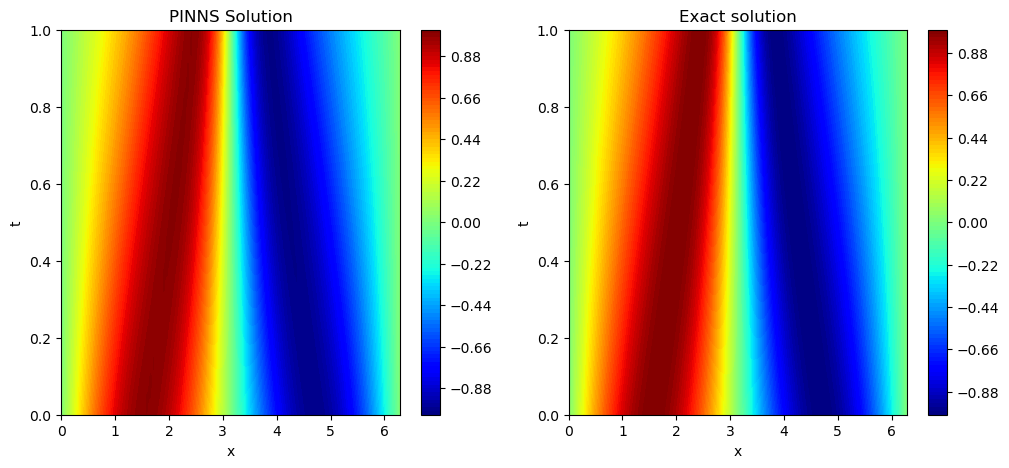

In [22]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="jet", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2))), cmap="jet", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

It seems PINNS solution is very close to the exact solution.

### Klein-Gordon equation

#### Case 1

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [1, 5]\times [0,T], $$
with initial conditions $$ \psi(x,0) = a \cos\left(\frac{\pi}{2} x \right) \quad\text{and}\quad \psi_t(x,0)=b\mu\cos\left(\frac{\pi}{2}x\right),$$
and Dirichlet boundary conditions $$ \psi(1,t) = \psi(5,t) = 0,$$

where $$\mu = \sqrt{b +\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t) = \cos\left(\frac{\pi x}{2}\right) \left(a \cos\left(\mu t \right) + b\sin\left(\mu t\right)\right).$$



In [78]:
#PINNS Solution

a = 2
b = 3
mu = np.sqrt(b + a**2 * np.pi**2 / 4)
t_min = 0
t_max = 2
x_min = 1
x_max = 5


def exact_solution(z):
    x = z[:,0:1]
    t = z[:,1:2]
    
    psi = np.cos(x*np.pi/2)*(a*np.cos(mu*t)+b*np.sin(mu*t))
    
    return psi
    
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x,t)

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[1],0)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)

bc_t_min_N = dde.icbc.NeumannBC(geom,lambda z: -b*mu*tf.cos(((np.pi)/2)*z[:,0:1]),ic_begin,component=0)

bcs = [bc_min_x, bc_max_x, bc_t_min_N]

def KG_deepxde(z,y):
    
    psi = y[:, 0:1]
    
    dpsi_dt = dde.grad.jacobian(psi,z,0,1)
    d2psi_dt2 = dde.grad.jacobian(dpsi_dt,z,0,1)
    dpsi_dx = dde.grad.jacobian(psi,z,0,0)
    d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
    
    return d2psi_dt2  - (a**2)* d2psi_dx2 + b*psi


def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    psi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return psi * tf.tanh(t) + a*tf.cos(((np.pi)/2)*x)


data = dde.data.PDE(geom, KG_deepxde,bcs, 
                        num_domain = 1500,
                        solution = exact_solution,
                        num_boundary = 30,
                        num_test = 100
                       )
    
net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'Glorot uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)

Compiling model...
Building feed-forward neural network...
'build' took 0.228425 s

'compile' took 4.025395 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.25e+02, 5.63e-02, 9.56e-03, 6.24e+01]    [3.48e+02, 5.63e-02, 9.56e-03, 6.24e+01]    []  
2000      [4.45e-01, 1.64e-03, 3.57e-02, 4.76e-02]    [4.06e-01, 1.64e-03, 3.57e-02, 4.76e-02]    []  

Best model at step 2000:
  train loss: 5.30e-01
  test loss: 4.91e-01
  test metric: []

'train' took 96.947859 s



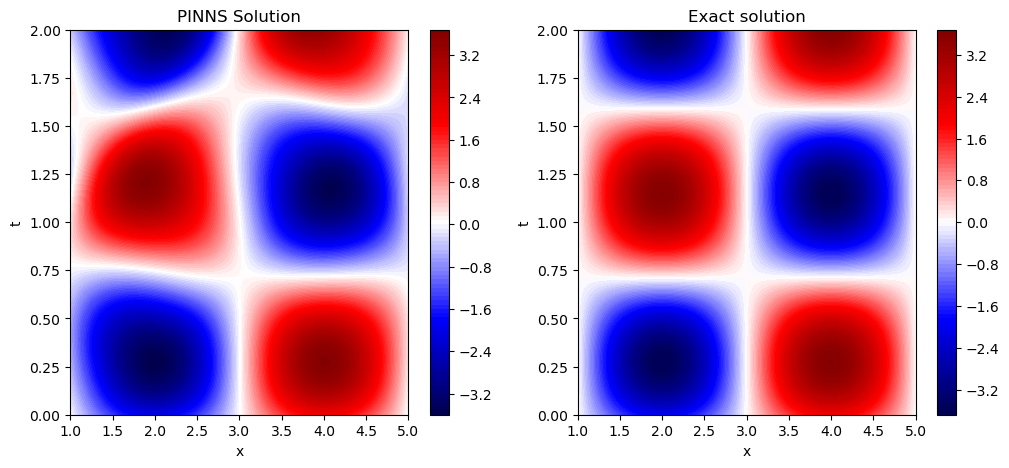

In [89]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.cos(X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T)), cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

So it seems the PINNS solutions if pretty close to the actual solution.

#### Case 2

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [0, 4]\times [0,T], $$

with initial conditions $$ \psi(x,0) = ae^{-\frac{\pi x}{2}} \quad \text{and}\quad \psi_t(x,0)=b\mu e^{-\frac{\pi}{2}x}$$
and boundary conditions
$$\psi(0, t) = a\cos(\mu t) + b\sin(\mu t)\qquad \text{and}\qquad
 \psi(4,t) = e^{-2\pi}\left(a\cos(\mu t) + b\sin(\mu t)\right)$$

where $$\mu = \sqrt{b -\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t)=e^{-\frac{\pi}{2} x}\left( a\cos(\mu t)+b\sin(\mu t)\right).$$

In [90]:
a = 1
b = 3
mu = np.sqrt(b - a**2 * np.pi**2 / 4)
t_min = 0; x_min = 0
t_max = 12
x_max = 4

x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x,t)


#PINNS Solution

def exact_solution(z):
    x = z[:,0:1]
    t = z[:,1:2]
    
    psi = np.exp(-(np.pi/2)*x)*(a*np.cos(mu*t)+b*np.sin(mu*t))
    
    return psi
    

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[1],0)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: a*tf.cos(mu*z[:,1:2])+b*tf.sin(mu*z[:,1:2]), boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: tf.exp(-2*np.pi)*(a*tf.cos(mu*z[:,1:2])+b*tf.sin(mu*z[:,1:2])), boundary_top,    component = 0)

bc_t_min_N = dde.icbc.NeumannBC(geom,lambda z: -b*mu*tf.exp(-(np.pi/2)*z[:,0:1]),ic_begin,component=0)

bcs = [bc_min_x, bc_max_x, bc_t_min_N]

def KG_deepxde(z,y):
    
    psi = y[:, 0:1]
    
    dpsi_dt = dde.grad.jacobian(psi,z,0,1)
    d2psi_dt2 = dde.grad.jacobian(dpsi_dt,z,0,1)
    dpsi_dx = dde.grad.jacobian(psi,z,0,0)
    d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
    
    return d2psi_dt2  - (a**2)* d2psi_dx2 + b*psi


def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    psi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return psi * tf.tanh(t) + a*tf.exp(-(np.pi/2)*x)


data = dde.data.PDE(geom, KG_deepxde,bcs, 
                        num_domain = 1500,
                        solution = exact_solution,
                        num_boundary = 30,
                        num_test = 100
                       )
    
net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'Glorot uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)


Compiling model...
Building feed-forward neural network...
'build' took 1.233928 s

'compile' took 25.927620 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.68e-01, 5.44e+00, 1.38e-01, 7.73e-01]    [3.46e-01, 5.44e+00, 1.38e-01, 7.73e-01]    []  
2000      [9.21e-04, 3.83e-04, 6.15e-06, 1.70e-06]    [9.07e-04, 3.83e-04, 6.15e-06, 1.70e-06]    []  

Best model at step 2000:
  train loss: 1.31e-03
  test loss: 1.30e-03
  test metric: []

'train' took 119.767562 s



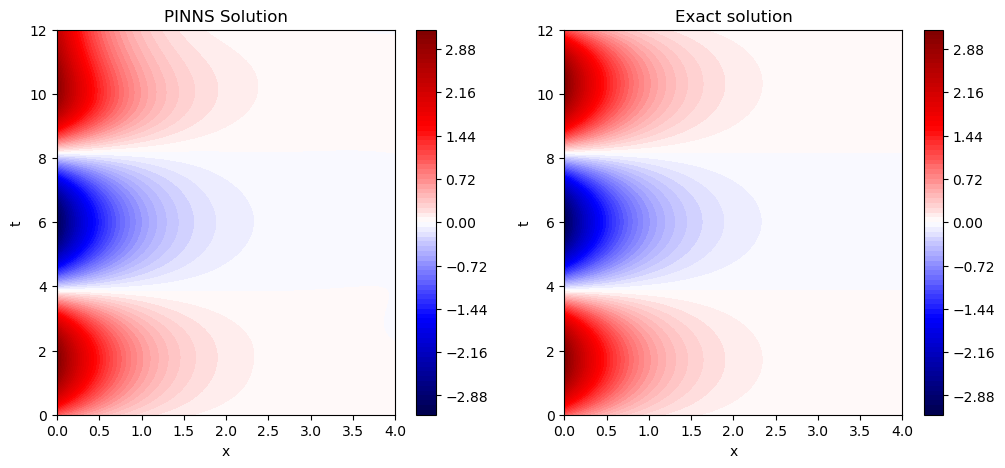

In [92]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.exp(-(np.pi/2)*X)*(a*np.cos(mu*T)+b*np.sin(mu*T)), cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

Again PINNS returns a very good approxiamte in this case.

## Parameter Identification without Noise

### A simple ODE

$$\frac{dy}{dx} =\cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.

* Use the following function to generate data points and learn the paramater $\omega^*=2$.

In [478]:
omega_star = 2.
x_max = 2*np.pi

def gen_data(num_pts=10, omega_star = omega_star):
    x = np.random.uniform(0, x_max, [num_pts, 1])
    return x, np.sin(omega_star*x)/omega_star


In [545]:
x = np.linspace(-np.pi, np.pi, 1000)
geom = dde.geometry.TimeDomain(x[0], x[-1])

x_begin = 0; y_begin = 0
def boundary_begin(x,_):  
    return dde.utils.isclose(x[0],x_begin)

def bc_func_begin(x,y,_): 
    
    return y - y_begin

bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)
points, ys = gen_data(omega_star = omega_star)
observe = dde.icbc.PointSetBC(points, ys )
bcs = [bc1, observe]

def Simple_ODE(omega_in, iter_in):

    omega = tf.Variable(omega_in)
    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 2, 
                        num_test = 100,
                   anchors = points)

    net = dde.nn.FNN([1] + [15]*6 + [1], 'sin', 'Glorot uniform')
    model = dde.Model(data, net)
    
    parameters = dde.callbacks.VariableValue([omega], period=200, filename = 'params.csv')
    
    
    model.compile('adam', lr = 0.03, metrics = [])
    losshistory, train_state = model.train(iterations = iter_in, 
                                           callbacks=[parameters],
                                          verbose = 0)
    

In [555]:
omega_ins = [5., 1.]
iter_in = 5000
omega_all = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
for k in range(len(omega_ins)):
    omega_in = omega_ins[k]
    
    params = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    trials = 3
    for j in range(trials):
        Simple_ODE(omega_in = omega_in, iter_in = iter_in)
        params0 = pd.read_csv('params.csv', header = None)
        params0.reset_index(inplace = True)
        params0.rename(columns = {'index':'Epoch', 0:'par_value' }, inplace = True)        
        params['par_value'+str(j)] = params0['par_value'].apply(lambda x: float(re.findall('\[\d.+',x)[0][1:-1]))

    omega_all['mean'+str(k)] = params[['par_value'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    omega_all['std' +str(k)] = params[['par_value'+str(t) for t in range(trials)]].apply(np.std, axis = 1)



Compiling model...
Building feed-forward neural network...
'build' took 0.189994 s

'compile' took 58.020289 s

Compiling model...
Building feed-forward neural network...
'build' took 0.309706 s

'compile' took 4.925166 s

Compiling model...
Building feed-forward neural network...
'build' took 0.826801 s

'compile' took 6.439524 s

Compiling model...
Building feed-forward neural network...
'build' took 0.150005 s

'compile' took 3.767120 s

Compiling model...
Building feed-forward neural network...
'build' took 0.157440 s

'compile' took 3.828671 s

Compiling model...
Building feed-forward neural network...
'build' took 0.283048 s

'compile' took 6.108091 s



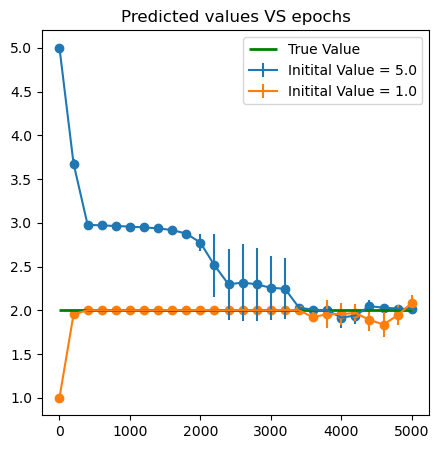

In [587]:
plt.figure(figsize = (5,5))
for k in range(2):
    plt.errorbar(x = omega_all['Epoch'], y = omega_all['mean'+str(k)], yerr = omega_all['std'+str(k)],label = f'Initital Value = {omega_ins[k]}')
    plt.scatter(x = omega_all['Epoch'], y = omega_all['mean'+str(k)])
plt.hlines(2., xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted values VS epochs')
plt.legend()
plt.show()

### Heat equation

$$w_t - \lambda w_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2\lambda t + 1\qquad \text{and}\qquad w(1,t)= 2\lambda t +2.$$
The exact solution is
$$w(x,t)=x^2 +2\lambda t+1.$$

* Use the following function to generate data points and learn the paramater $\lambda^*=0.5$.

In [590]:

def gen_data(num_pts=10, lmbda_star = 0.5):
    z = np.random.uniform(0, 1, [num_pts, 2])
    return z, z[:,0:1]**2 + 2*lmbda_star*z[:,1:2] + 1

In [694]:


geom = dde.geometry.Rectangle((0,0), (1, 1))
x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)


def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)

lmbda_star = 0.5
bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*lmbda_star*z[:,0:1] + 1, boundary_bottom)
bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*lmbda_star*z[:,0:1] + 2, boundary_top)
bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)
    
points, ws = gen_data(lmbda_star = lmbda_star)
observe   = dde.icbc.PointSetBC(points, ws)
bcs = [bc_bottom,bc_top,bc_ic,observe]


def HEAT_PDE(l_in , iters_in):
    
    Lambda = tf.Variable(l_in)
    
    

    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - Lambda * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 50)
    
    net = dde.nn.FNN([2] + [30]*5 + [1], 'sin', 'Glorot normal')
    parameters = dde.callbacks.VariableValue([Lambda], period=200, filename = 'params.csv')

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.1, metrics = [])
    losshistory, train_state = model.train(iterations = iters_in, 
                                           callbacks=[parameters],
                                          verbose = 0)



In [696]:
lambda_ins = [1., 0.1]
iter_in = 4000
lambda_all = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
for k in range(len(lambda_ins)):
    l_in = lambda_ins[k]
    
    params = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    trials = 3
    for j in range(trials):
        HEAT_PDE(l_in , iter_in)
        params0 = pd.read_csv('params.csv', header = None)
        params0.reset_index(inplace = True)
        params0.rename(columns = {'index':'Epoch', 0:'par_value' }, inplace = True)        
        params['par_value'+str(j)] = params0['par_value'].apply(lambda x: float(re.findall('\[.+',x)[0][1:-1]))

    lambda_all['mean'+str(k)] = params[['par_value'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    lambda_all['std' +str(k)] = params[['par_value'+str(t) for t in range(trials)]].apply(np.std, axis = 1)



Compiling model...
Building feed-forward neural network...
'build' took 2.098721 s

'compile' took 23.328576 s

Compiling model...
Building feed-forward neural network...
'build' took 2.314242 s

'compile' took 16.947184 s

Compiling model...
Building feed-forward neural network...
'build' took 1.294780 s

'compile' took 15.030651 s

Compiling model...
Building feed-forward neural network...
'build' took 1.500192 s

'compile' took 11.203692 s

Compiling model...
Building feed-forward neural network...
'build' took 0.556046 s

'compile' took 9.557672 s

Compiling model...
Building feed-forward neural network...
'build' took 1.318314 s

'compile' took 122.568636 s



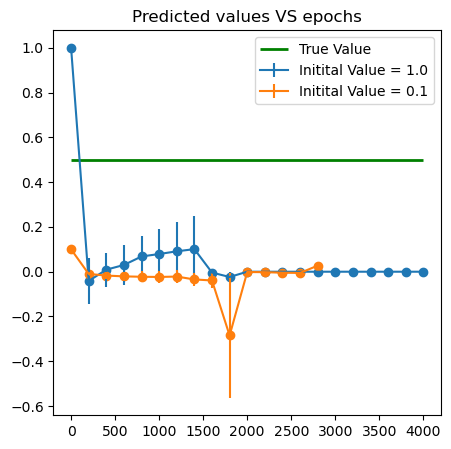

In [698]:
plt.figure(figsize = (5,5))
for k in range(len(lambda_ins)):
    plt.errorbar(x = lambda_all['Epoch'], y = lambda_all['mean'+str(k)], yerr = lambda_all['std'+str(k)],label = f'Initital Value = {lambda_ins[k]}')
    plt.scatter(x = lambda_all['Epoch'], y = lambda_all['mean'+str(k)])
plt.hlines(0.5, xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted values VS epochs')
plt.legend()
plt.show()

### A system of linear PDEs


Consider the system \begin{cases}
v_t - \frac{1}{2} v_{xx} = \alpha v +\beta w,\\
w_t - \frac{1}{2} w_{xx} = \gamma v + \delta w.
\end{cases}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(t+1\right)e^{-t}, \\
v(1,t) = \left(t+2\right)e^{-t},\\
w(0,t) = \left(t+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(t+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}

The exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + t + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + t + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

The true parameters are
$$
\alpha^* =  -1, \quad \beta^* = 0, \quad \gamma^* = 1, \quad \delta^* =-2,$$


* Use data generated from the exact solution to leanr the parameters $\alpha, \beta, \gamma$ and $ \delta$.

In [702]:
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + T + 1)*(np.exp(-T) - np.exp(-2*T))
def gen_data(num_pts=10):
    Z = np.random.uniform(0, 1, [num_pts, 2])
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    return Z, np.stack([v.flatten(), w.flatten()], 1)

In [714]:

geom = dde.geometry.Rectangle((0,0), (1, 1))

x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)


a = 0.5

bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

points, Zs = gen_data(10)
obs_v = dde.icbc.PointSetBC(points, Zs[:,0:1],component = 0)
obs_w = dde.icbc.PointSetBC(points, Zs[:,1:2],component = 1)

bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w, obs_v, obs_w]

def HEAT2_PDE(alpha = tf.Variable(-1.),
              beta = tf.Variable(0.), 
              gamma = tf.Variable(1.), 
              delta = tf.Variable(-2.), iters_in = 4000):

    def HEAT2_deepxde(z,y):
    
        v = y[:,0:1]
        w = y[:,1:2]
    
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        dv_dt = dde.grad.jacobian(v,z,0,0)
        dv_dx = dde.grad.jacobian(v,z,0,1)
        d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
        return [
            dv_dt - a * d2v_dx2 - alpha*v - beta*w,
            dw_dt - a * d2w_dx2 - gamma*v - delta*w
            ]

    def output_transform(z, q): # With this transformation the initial conditions are automatically satisfied.
        v = q[:, 0:1]
        w = q[:, 1:2]
        t = z[:, 0:1]
        x = z[:, 1:2]
        return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


    data = dde.data.PDE(geom, HEAT2_deepxde,bcs, 
                        num_domain = 1500,
                        num_boundary = 60,
                   anchors = points)
    
    net = dde.nn.FNN([2] + [30]*3 + [2], 'sin', 'Glorot uniform')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([alpha,beta,gamma,delta], period = 200, filename = 'params.csv')


    model = dde.Model(data, net)
    model.compile('adam', lr = 0.05, metrics = [])
    losshistory, train_state = model.train(iterations = iters_in, 
                                           callbacks = [parameters],
                                          verbose = 0)
    
  

In [750]:
pars = [[-2.,-1.,0.,-3.],
       [-1.5,-0.5,0.5,-2.5],
       [-0.5,0.5,2.,-1.5] ]

iter_in = 4000
alpha_all = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
beta_all  = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
gamma_all = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
delta_all = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
for k in range(len(pars)):
    
    alpha_df = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    beta_df  = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    gamma_df = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    delta_df = pd.DataFrame({'Epoch':[200*i for i in range(int(1+iter_in/200))]})
    trials = 3
    for j in range(trials):
        HEAT2_PDE(alpha = tf.Variable(pars[k][0]),
              beta = tf.Variable(pars[k][1]), 
              gamma = tf.Variable(pars[k][2]), 
              delta = tf.Variable(pars[k][3]), iters_in = iter_in)
        params0 = pd.read_csv('params.csv', header = None)
        params0.reset_index(inplace = True)
        params0.rename(columns = {'index':'Epoch', 
                                  0:'par_value_a', 
                                  1:'par_value_b', 
                                  2:'par_value_g', 
                                  3:'par_value_d'}, inplace = True)        
        alpha_df['par_value_a'+str(j)] = params0['par_value_a'].apply(lambda x: float(re.findall('\[.+',x)[0][1:]))
        beta_df['par_value_b'+str(j)]  = params0['par_value_b'].apply(lambda x: float(x))
        gamma_df['par_value_g'+str(j)] = params0['par_value_g'].apply(lambda x: float(x))
        delta_df['par_value_d'+str(j)] = params0['par_value_d'].apply(lambda x: float(re.findall('[^\s].+\]',x)[0][0:-1]))

    
    alpha_all['mean'+str(k)] = alpha_df[['par_value_a'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    alpha_all['std' +str(k)] = alpha_df[['par_value_a'+str(t) for t in range(trials)]].apply(np.std, axis = 1)

    beta_all['mean'+str(k)]  = beta_df[['par_value_b'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    beta_all['std' +str(k)]  = beta_df[['par_value_b'+str(t) for t in range(trials)]].apply(np.std, axis = 1)

    gamma_all['mean'+str(k)] = gamma_df[['par_value_g'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    gamma_all['std' +str(k)] = gamma_df[['par_value_g'+str(t) for t in range(trials)]].apply(np.std, axis = 1)

    delta_all['mean'+str(k)] = delta_df[['par_value_d'+str(t) for t in range(trials)]].apply(np.mean, axis = 1)
    delta_all['std' +str(k)] = delta_df[['par_value_d'+str(t) for t in range(trials)]].apply(np.std, axis = 1)



Compiling model...
Building feed-forward neural network...
'build' took 2.524323 s

'compile' took 49.372182 s

Compiling model...
Building feed-forward neural network...
'build' took 1.829119 s

'compile' took 33.048150 s

Compiling model...
Building feed-forward neural network...
'build' took 2.164115 s

'compile' took 33.978227 s

Compiling model...
Building feed-forward neural network...
'build' took 1.835835 s

'compile' took 29.137035 s

Compiling model...
Building feed-forward neural network...
'build' took 2.062183 s

'compile' took 32.488103 s

Compiling model...
Building feed-forward neural network...
'build' took 1.754556 s

'compile' took 30.347081 s

Compiling model...
Building feed-forward neural network...
'build' took 2.271212 s

'compile' took 44.217233 s

Compiling model...
Building feed-forward neural network...
'build' took 2.939695 s

'compile' took 43.373881 s

Compiling model...
Building feed-forward neural network...
'build' took 2.373332 s

'compile' took 52.32

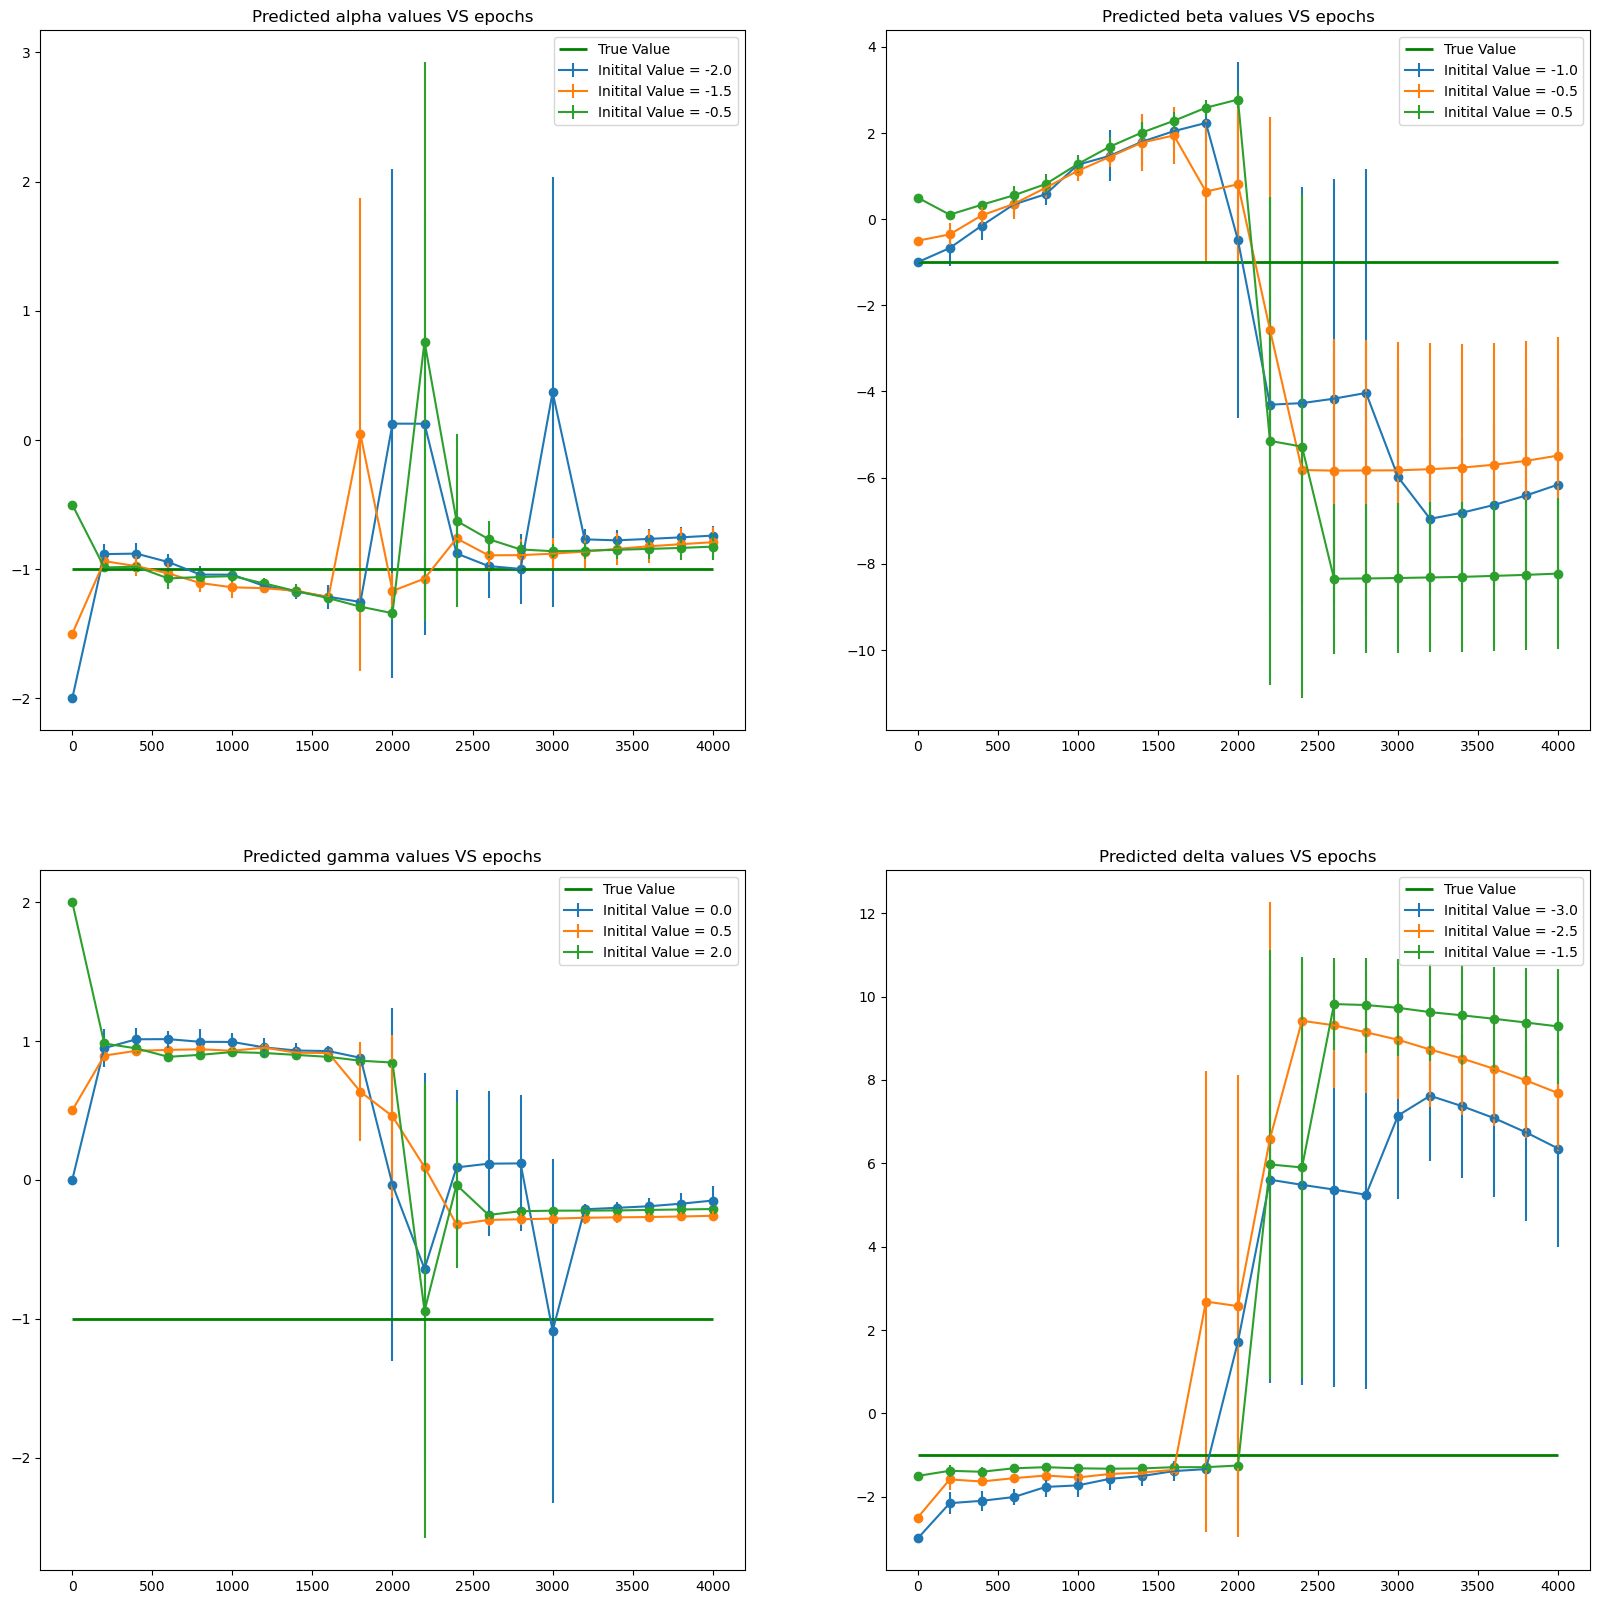

In [755]:
plt.figure(figsize = (20,20))

plt.subplot(221)
for k in range(len(pars)):
    plt.errorbar(x = alpha_all['Epoch'], y = alpha_all['mean'+str(k)], yerr = alpha_all['std'+str(k)],label = f'Initital Value = {pars[k][0]}')
    plt.scatter( x = alpha_all['Epoch'], y = alpha_all['mean'+str(k)])
plt.hlines(-1., xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted alpha values VS epochs')
plt.legend()

plt.subplot(222)
for k in range(len(pars)):
    plt.errorbar(x = beta_all['Epoch'], y = beta_all['mean'+str(k)], yerr = beta_all['std'+str(k)],label = f'Initital Value = {pars[k][1]}')
    plt.scatter( x = beta_all['Epoch'], y = beta_all['mean'+str(k)])
plt.hlines(-1., xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted beta values VS epochs')
plt.legend()

plt.subplot(223)
for k in range(len(pars)):
    plt.errorbar(x = gamma_all['Epoch'], y = gamma_all['mean'+str(k)], yerr = gamma_all['std'+str(k)],label = f'Initital Value = {pars[k][2]}')
    plt.scatter( x = gamma_all['Epoch'], y = gamma_all['mean'+str(k)])
plt.hlines(-1., xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted gamma values VS epochs')
plt.legend()

plt.subplot(224)
for k in range(len(pars)):
    plt.errorbar(x = delta_all['Epoch'], y = delta_all['mean'+str(k)], yerr = delta_all['std'+str(k)],label = f'Initital Value = {pars[k][3]}')
    plt.scatter( x = delta_all['Epoch'], y = delta_all['mean'+str(k)])
plt.hlines(-1., xmin = 0, xmax = iter_in, color = 'green',linewidth = 2., label = 'True Value')
plt.title('Predicted delta values VS epochs')
plt.legend()

plt.show()

### Helmholtz equation

We want to determine $\lambda$ for which $$\nabla^2 E(x,y) + \lambda E(x,y) = 0,\qquad x,y \in \Omega =[-2, 2]^2,$$
subject to boundary conditions
$$E(-2,y)=E(2,y)=-\cos\left(\frac{\pi}{2} y\right)-\sin\left(\frac{\pi}{2} y\right),$$
$$E(x,-2)=E(x, 2)=-\cos\left(\frac{\pi}{2} x\right)-\sin\left(\frac{\pi}{2} x\right).$$

We draw data points from the particular solution $$ E^*(x,y) = \cos\frac{\pi\left(x- y\right)}{2}+ \sin\frac{\pi\left(x + y\right)}{2}.$$

The true value is $\lambda^* =\frac{\pi^2}{2}$.


* Learn $\lambda$ from data using the function.

In [757]:
def helm_sol(X, Y):
    return np.cos((X-Y)*np.pi/2)+np.sin((X+Y)*np.pi/2)

def helm_data(num_pts=10):
    X = np.random.uniform(-2, 2, num_pts)
    Y = np.random.uniform(-2, 2, num_pts)
    Z = np.stack([X, Y], 1)
    return Z, helm_sol(X, Y).reshape(num_pts, 1)


x_min = -2; x_max = 2
y_min = -2; y_max = 2
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)

In [759]:
geom = dde.geometry.Rectangle((x_min,y_min), (x_max,y_max))

def boundary_xmin(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_xmax(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def boundary_ymin(z,on_boundary):  
    return dde.utils.isclose(z[1],y_min)

def boundary_ymax(z,on_boundary):  
    return dde.utils.isclose(z[1],y_max)

bc_min_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmin, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmax, component = 0)

bc_min_y = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymin, component = 0)
bc_max_y = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymax, component = 0)

points, Es = helm_data(num_pts = 10)
observe = dde.icbc.PointSetBC(points, Es )

bcs = [bc_min_x, bc_max_x,bc_min_y, bc_max_y, observe]
def Helmholtz_PDE(l_in, iter_in):
    iters = iter_in
    Lambda = tf.Variable(l_in)
    def Helmholtz_deepxde(z,h):
    
        E = h[:, 0:1]
    
        dE_dx = dde.grad.jacobian(E,z,0,0)
        d2E_dx2 = dde.grad.jacobian(dE_dx,z,0,0)
        dE_dy = dde.grad.jacobian(E,z,0,1)
        d2E_dy2 = dde.grad.jacobian(dE_dy,z,0,1)
    
    
        return d2E_dx2 + d2E_dy2 + Lambda * E

    data = dde.data.PDE(geom, Helmholtz_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 100,
                        num_test = 50
                       )

    net = dde.nn.FNN([2] + [60]*5 + [1], 'sin', 'Glorot normal')
    parameters = dde.callbacks.VariableValue([Lambda], period = 200, filename = 'params.csv' )
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = iters, 
                                           display_every = 1000,
                                           verbose = 0,
                                           callbacks = [parameters])
    
    Z_pred = model.predict(np.stack((X.ravel(), Y.ravel()), axis=-1)).reshape(len(x), len(y), 1)

    
    
    


In [761]:
l_ins = [7.]
iter_in = 4000
lambda_all = pd.DataFrame({'Epoch':[200*i for i in range(21)]})
for k in range(len(l_ins)):
    l_in = l_ins[k]
    
    params = pd.DataFrame({'Epoch':[200*i for i in range(21)]})
    for j in range(3):
        Helmholtz_PDE(l_in = l_in, iter_in = iter_in)
        params0 = pd.read_csv('params.csv', header = None)
        params0.reset_index(inplace = True)
        params0.rename(columns = {'index':'Epoch', 0:'par_value' }, inplace = True)        
        params['par_value'+str(j)] = params0['par_value'].apply(lambda x: float(re.findall('\[\d.+',x)[0][1:-1]))

    lambda_all['mean'+str(k)] = params[['par_value0','par_value1','par_value2']].apply(np.mean, axis = 1)
    lambda_all['std'+str(k)] =  params[['par_value0','par_value1','par_value2']].apply(np.std, axis = 1)






Compiling model...
Building feed-forward neural network...
'build' took 4.601998 s

'compile' took 44.068607 s

Compiling model...
Building feed-forward neural network...
'build' took 4.493658 s

'compile' took 361.937912 s

Compiling model...
Building feed-forward neural network...
'build' took 4.010431 s

'compile' took 36.095186 s



<Figure size 1000x1000 with 0 Axes>

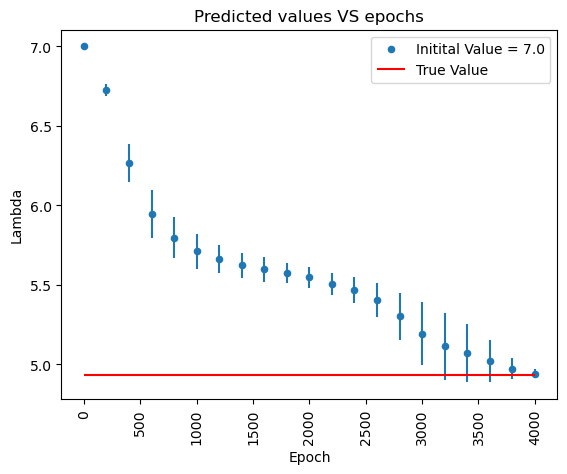

In [470]:
plt.figure(figsize = (10,10))
for k in range(1):
    lambda_all.plot.scatter(x = 'Epoch', y = 'mean'+str(k), yerr = 'std'+str(k), rot = 'vertical', ylabel = 'Lambda', label = f'Initital Value = {l_ins[k]}')
plt.hlines((np.pi**2)/2, xmin = 0, xmax = 4000, color = 'red', label = 'True Value')
plt.title('Predicted values VS epochs')
plt.legend()
plt.show()

### Hamilton-Jacobi equation

The goal is to see whether it is possible to learn $a$ and $b$ from data in the following equation \begin{array}{l}a \varphi_t+b\sin(x)\varphi_x = 0, \;  x\in[-\pi, \pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(-\pi, t) = \varphi(\pi, t)= 0.  \end{array}

The true parameters we want to learn are $a^*=b^*=1$, for which the exact solution is
$$
\varphi(x,t) = \sin\left(2\arctan\left(e^{-t}\tan\left(\frac{x}{2} \right)\right)\right)
$$

1. Try learning $a$ and $b$ from data using the function above.
2. Can you explain the issue?

In [30]:
def gen_data(num_pts=100):
    X = np.random.uniform(-np.pi, np.pi, num_pts)
    T = np.random.uniform(0, 1, num_pts)
    return np.stack([X,T], 1), np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2))).reshape(num_pts, 1)

def phi_exact(z):
    t = z[:,1:2]
    x = z[:,0:1]
    
    return np.sin(2*np.arctan(np.exp(-t)*np.tan(x/2)))

In [31]:
# PINNS Solution:

t_max = 1; t_min = 0
x_max = np.pi; x_min = -np.pi
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)

points, phis = gen_data()
obs_phi = dde.icbc.PointSetBC(points, phis,component = 0)

bcs = [bc_min_x, bc_max_x, obs_phi]

def HJ_PDE(a_in, b_in, iter_in):
    
    iters = iter_in
    a = tf.Variable(a_in)
    b = tf.Variable(b_in)
    
    def HJ_deepxde(z,y):
    
        phi = y[:, 0:1]
        x = z[:, 0:1]
        t = z[:, 1:2]
    
        dphi_dt = dde.grad.jacobian(phi,z,0,1)
        dphi_dx = dde.grad.jacobian(phi,z,0,0)
    
    
        return a*dphi_dt  + b*tf.sin(x) * dphi_dx

    def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
        phi = q[:, 0:1]
    
        x = z[:, 0:1]
        t = z[:, 1:2]
    
        return phi * tf.tanh(t) + tf.sin(x)

    data = dde.data.PDE(geom, HJ_deepxde,bcs, 
                        num_domain = 2000,
                        num_boundary = 45,
                        anchors = points,
                        num_test = 50
                       )
                       
    net = dde.nn.FNN([2] + [40]*3 + [1], 'tanh', 'He normal')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([a, b], period = 200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    
    
    losshistory, train_state = model.train(iterations = iters, callbacks = [parameters])
    
    Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t),1)
    Z_true = phi_exact(np.stack((X.ravel(), T.ravel()), axis = -1)).reshape(len(x), len(t),1)
    
    err = dde.metrics.l2_relative_error(Z_true,Z_pred)
    
    return parameters.value, err

In [32]:
As = [0.7, 1., 1.3]
Bs = [0.7, 1., 1.3]

iter_num = [1000, 1200, 1400, 1600, 1800, 2000, 2200]

iter_a = []
err_a  = [] 
for a in As:
    for it in iter_num:
        opt, err = HJ_PDE(a_in=a, b_in=1., iter_in = it)
        iter_a.append(opt[0])
        err_a.append(err)

iter_b = []
err_b  = []
for b in Bs:
    for it in iter_num:
        opt, err = HJ_PDE(a_in=1., b_in=b, iter_in = it)
        iter_b.append(opt[1])
        err_b.append(err)


Compiling model...
Building feed-forward neural network...
'build' took 0.682251 s

'compile' took 5.348308 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.46e-01, 7.11e-02, 2.25e-03, 2.52e-01]    [3.74e-01, 7.11e-02, 2.25e-03, 2.52e-01]    []  
0 [7.00e-01, 1.00e+00]
200 [6.88e-01, 4.70e-01]
400 [5.32e-01, 3.90e-01]
600 [4.11e-01, 3.67e-01]
800 [3.57e-01, 3.43e-01]
1000      [9.22e-04, 3.55e-03, 1.48e-02, 2.40e-03]    [7.52e-04, 3.55e-03, 1.48e-02, 2.40e-03]    []  
1000 [3.30e-01, 3.23e-01]

Best model at step 1000:
  train loss: 2.17e-02
  test loss: 2.15e-02
  test metric: []

'train' took 21.878651 s

Compiling model...
Building feed-forward neural network...
'build' took 0.133566 s

'compile' took 4.466806 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.56e-01, 1.66e-02, 1.09e-01, 1.35e-01

Compiling model...
Building feed-forward neural network...
'build' took 0.405158 s

'compile' took 4.560438 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.40e-01, 1.45e-01, 3.07e-01, 1.41e-01]    [5.31e-01, 1.45e-01, 3.07e-01, 1.41e-01]    []  
0 [1.00e+00, 1.00e+00]
200 [9.06e-01, 4.60e-01]
400 [7.44e-01, 4.14e-01]
600 [5.64e-01, 4.04e-01]
800 [4.21e-01, 3.49e-01]
1000      [5.34e-04, 1.43e-05, 4.40e-05, 8.55e-04]    [4.44e-04, 1.43e-05, 4.40e-05, 8.55e-04]    []  
1000 [3.17e-01, 2.85e-01]
1200 [2.46e-01, 2.36e-01]
1400      [1.66e-04, 4.37e-06, 1.21e-05, 2.41e-04]    [1.11e-04, 4.37e-06, 1.21e-05, 2.41e-04]    []  
1400 [1.90e-01, 1.85e-01]

Best model at step 1400:
  train loss: 4.24e-04
  test loss: 3.69e-04
  test metric: []

'train' took 26.402244 s

Compiling model...
Building feed-forward neural network...
'build' took 0.170232 s

'compile' took 3.251288 s

Training model...

Step

1400 [5.16e-01, 4.70e-01]
1600      [3.36e-04, 4.52e-06, 2.18e-05, 3.01e-04]    [3.19e-04, 4.52e-06, 2.18e-05, 3.01e-04]    []  
1600 [4.40e-01, 4.06e-01]

Best model at step 1600:
  train loss: 6.63e-04
  test loss: 6.46e-04
  test metric: []

'train' took 31.487823 s

Compiling model...
Building feed-forward neural network...
'build' took 0.330779 s

'compile' took 5.081003 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.09e-01, 8.15e-02, 1.70e-01, 1.25e-01]    [7.96e-01, 8.15e-02, 1.70e-01, 1.25e-01]    []  
0 [1.30e+00, 1.00e+00]
200 [1.19e+00, 4.94e-01]
400 [1.05e+00, 4.39e-01]
600 [8.50e-01, 4.76e-01]
800 [6.44e-01, 4.53e-01]
1000      [1.69e-03, 5.17e-05, 2.12e-04, 2.62e-03]    [1.50e-03, 5.17e-05, 2.12e-04, 2.62e-03]    []  
1000 [4.80e-01, 3.97e-01]
1200 [3.68e-01, 3.29e-01]
1400 [2.85e-01, 2.63e-01]
1600 [2.26e-01, 2.18e-01]
1800      [1.10e-04, 2.26e-06, 8.20e-06, 1.92e-04]    [7

0 [1.00e+00, 7.00e-01]
200 [7.82e-01, 3.05e-01]
400 [4.58e-01, 2.56e-01]
600 [1.73e-01, 1.30e-01]
800 [3.36e-02, 2.99e-02]
1000      [3.25e-07, 4.46e-05, 7.33e-06, 2.30e-03]    [2.78e-07, 4.46e-05, 7.33e-06, 2.30e-03]    []  
1000 [3.73e-03, 3.21e-03]
1200 [3.44e-04, 3.40e-04]
1400 [3.03e-05, 3.00e-05]
1600 [2.45e-06, 2.41e-06]
1800 [2.07e-07, 1.96e-07]
2000      [5.77e-18, 6.40e-06, 9.29e-06, 3.73e-04]    [2.71e-18, 6.40e-06, 9.29e-06, 3.73e-04]    []  
2000 [1.81e-08, 1.83e-08]

Best model at step 2000:
  train loss: 3.88e-04
  test loss: 3.88e-04
  test metric: []

'train' took 44.555014 s

Compiling model...
Building feed-forward neural network...
'build' took 1.181676 s

'compile' took 11.665940 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.34e-01, 8.91e-02, 3.22e-02, 1.49e-01]    [6.66e-01, 8.91e-02, 3.22e-02, 1.49e-01]    []  
0 [1.00e+00, 7.00e-01]
200 [8.82e-01, 3.15e-01]
400 [7.

2200 [3.31e-01, 3.24e-01]

Best model at step 2000:
  train loss: 1.03e-04
  test loss: 6.95e-05
  test metric: []

'train' took 52.348735 s

Compiling model...
Building feed-forward neural network...
'build' took 1.291746 s

'compile' took 13.182342 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.50e-01, 2.11e-01, 6.16e-02, 9.78e-02]    [3.27e-01, 2.11e-01, 6.16e-02, 9.78e-02]    []  
0 [1.00e+00, 1.30e+00]
200 [1.09e+00, 6.96e-01]
400 [9.73e-01, 6.06e-01]
600 [7.98e-01, 6.25e-01]
800 [6.93e-01, 6.03e-01]
1000      [5.67e-04, 2.99e-05, 1.95e-05, 3.70e-04]    [5.55e-04, 2.99e-05, 1.95e-05, 3.70e-04]    []  
1000 [6.28e-01, 5.68e-01]

Best model at step 1000:
  train loss: 9.87e-04
  test loss: 9.75e-04
  test metric: []

'train' took 48.417022 s

Compiling model...
Building feed-forward neural network...
'build' took 1.102509 s

'compile' took 14.245086 s

Training model...

Step      Train

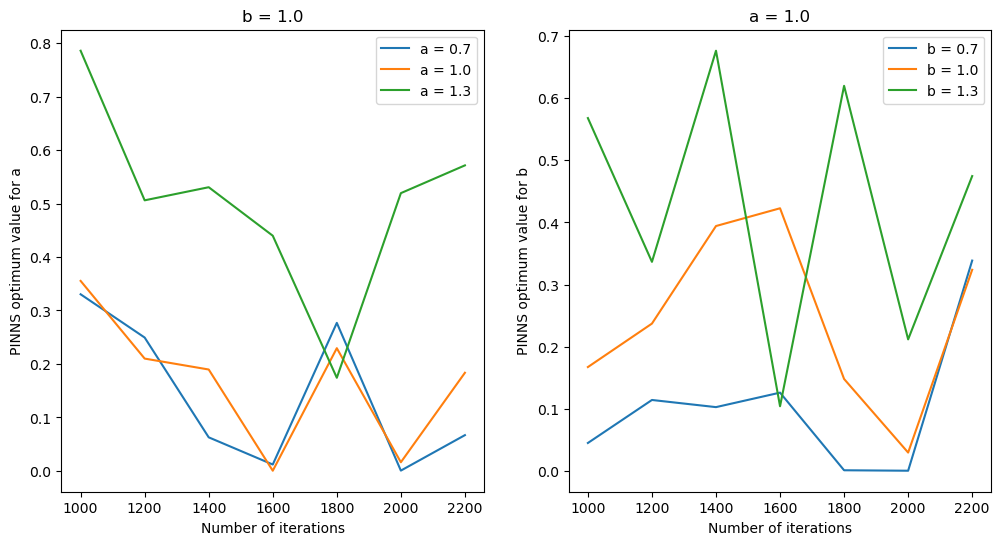

In [33]:
iters_a = np.array(iter_a).reshape(3,7)
iters_b = np.array(iter_b).reshape(3,7)

plt.figure(figsize = (12,6))

plt.subplot(121)
for i in range(len(As)):
    plt.plot(iter_num, iters_a[i,:], label = 'a = {}'.format(As[i]))
plt.xlabel('Number of iterations')
plt.ylabel('PINNS optimum value for a')
plt.title('b = 1.0')
plt.legend()

plt.subplot(122)
for i in range(len(Bs)):
    plt.plot(iter_num, iters_b[i,:], label = 'b = {}'.format(Bs[i]))
plt.xlabel('Number of iterations')
plt.ylabel('PINNS optimum value for b')
plt.title('a = 1.0')
plt.legend()

plt.show()

This graphs shows (a,b) values don't converge to the expected point  $(a^*,b^*) = (1,1)$.

The follwing graphs for mean_error versus the values of (a,b) shows the point (1,1) is not a minimum of the l2_error function.

#### In this graph the blue line is the l2_relative error for different valuse of 'a' in the set [0.7, 1, 1.3]
#### Similarly, the orange line is the l2_relative error for different valuse of 'b' in the set [0.7, 1, 1.3]

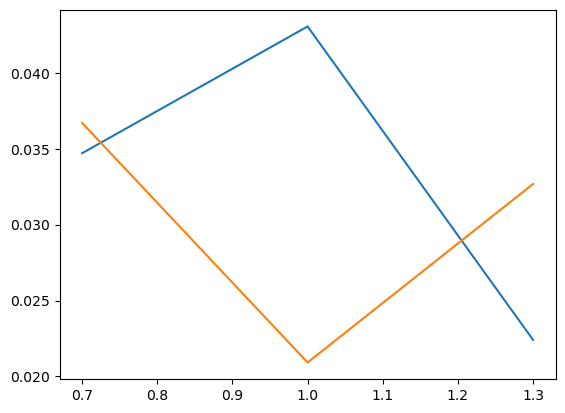

In [37]:
mean_err_a = [np.mean(err_a[i,:]) for i in range(len(As))]
mean_err_b = [np.mean(err_b[i,:]) for i in range(len(Bs))]

plt.plot(As, mean_err_a)
plt.plot(Bs, mean_err_b)

## Parameter Identification with noise

### Simple ODE

$$\frac{dy}{dx} =\cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.

* Use the following function to generate data points and learn the paramater $\omega^*=2$. Try with different levels of noise. Use the parameter `eps` to set the amplitude of the noise.

In [3]:
omega_star = 2
x_max = 2*np.pi

def gen_data(eps=0.1):
    x = np.random.uniform(0, x_max, [10, 1])
    noise = eps*np.random.uniform(-1, 1, [10, 1])
    return x, np.sin(omega_star*x)/omega_star + noise

In [5]:
def noisy_params(eps, omega_0 = 1.): # We train the FNN with different values of noise amplitudes. We'll plot the final values for
                       # for Omega in each case. These numbers are close to the expected values...

    omega = tf.Variable(omega_0)
    
    geom = dde.geometry.TimeDomain(-np.pi, np.pi)

    x_begin = 0; y_begin = 0
    def boundary_begin(x,_):  
        return dde.utils.isclose(x[0],x_begin)

    def bc_func_begin(x,y,_): 
        return y - y_begin

    bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)

    points, ys = gen_data(eps)
    observe = dde.icbc.PointSetBC(points, ys )

    bcs = [bc1, observe]


    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 1, 
                        num_test = 200,
                       anchors = points)

    net = dde.nn.FNN([1] + [60]*4 + [1], 'tanh', 'He uniform')
    model = dde.Model(data, net)
    
    parameters = dde.callbacks.VariableValue([omega], period=200)
    
    
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks=[parameters])

    
    return parameters.value

Compiling model...
Building feed-forward neural network...
'build' took 0.226469 s

'compile' took 1.382866 s

Training model...

0         [7.26e-01, 0.00e+00, 3.17e-01]    [7.28e-01, 0.00e+00, 3.17e-01]    []  
0 [1.00e+00]
200 [1.02e+00]
400 [1.92e+00]
600 [1.99e+00]
800 [1.99e+00]
1000      [3.11e-04, 1.42e-07, 4.67e-05]    [1.86e-04, 1.42e-07, 4.67e-05]    []  
1000 [1.99e+00]

Best model at step 1000:
  train loss: 3.58e-04
  test loss: 2.33e-04
  test metric: []

'train' took 8.212533 s

Compiling model...
Building feed-forward neural network...
'build' took 0.136385 s

'compile' took 1.634719 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.10e+00, 0.00e+00, 1.13e-01]    [1.12e+00, 0.00e+00, 1.13e-01]    []  
0 [1.00e+00]
200 [7.24e-01]
400 [8.35e-01]
600 [9.49e-01]
800 [1.90e+00]
1000      [9.21e-04, 3.05e-08, 1.55e-03]    [1.21e-04, 3.05e-08, 1.55e-03]    []  
1000 [1.94e+00]

Best model at step 1000:

'build' took 0.119791 s

'compile' took 3.057362 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.50e+00, 0.00e+00, 4.57e-01]    [1.54e+00, 0.00e+00, 4.57e-01]    []  
0 [2.00e+00]
200 [1.69e+00]
400 [2.08e+00]
600 [2.13e+00]
800 [2.13e+00]
1000      [2.79e-04, 8.60e-06, 4.59e-03]    [1.80e-04, 8.60e-06, 4.59e-03]    []  
1000 [2.14e+00]

Best model at step 1000:
  train loss: 4.88e-03
  test loss: 4.78e-03
  test metric: []

'train' took 13.401438 s

Compiling model...
Building feed-forward neural network...
'build' took 0.070046 s

'compile' took 1.722689 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.50e-01, 0.00e+00, 1.16e+00]    [5.47e-01, 0.00e+00, 1.16e+00]    []  
0 [2.00e+00]
200 [1.89e+00]
400 [1.90e+00]
600 [1.91e+00]
800 [1.90e+00]
1000      [3.78e-03, 2.73e-05, 2.99e-02]    [1.00e-03, 2.73e-05, 2.99e-02]    []  
1000 [1.9

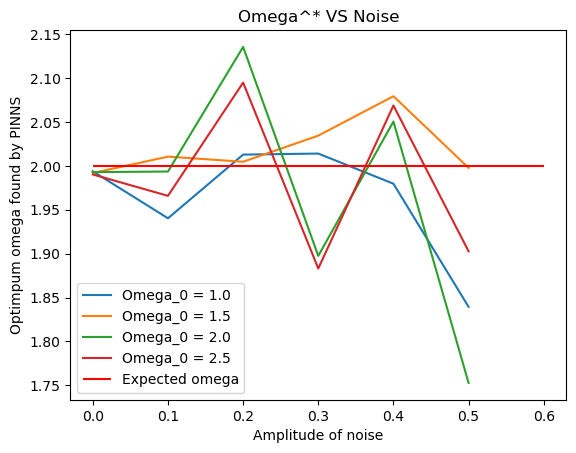

In [8]:
for omega_0 in [1., 1.5, 2., 2.5]:

    omega_vals = [] 
    for e in np.linspace(0,0.5,6):
        val = noisy_params(e, omega_0 = omega_0)
        omega_vals.append(val)
    plt.plot(np.linspace(0,0.5,6), omega_vals, label = 'Omega_0 = {}'.format(omega_0))

plt.hlines(2, 0, 0.6, color = 'r', label='Expected omega')
plt.ylabel('Optimpum omega found by PINNS')
plt.xlabel('Amplitude of noise')
plt.title('Omega^* VS Noise')
plt.legend()

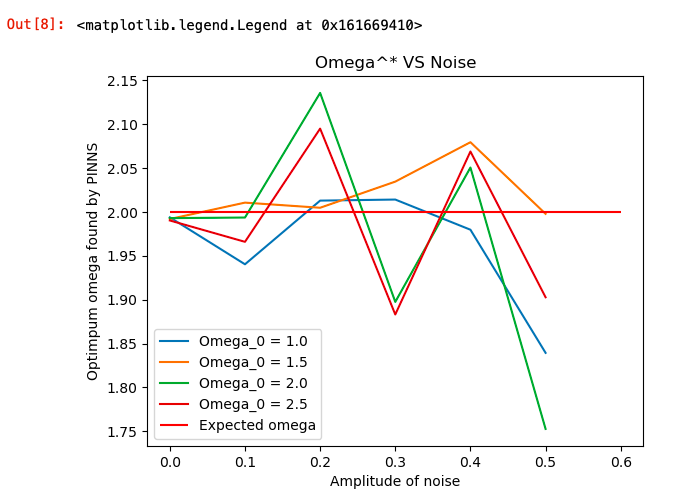

From the graph above for different values of $\omega_0$, the value of $\omega$ found by PINNS diverges from the true value $\omega_0$. 

### Heat equation

$$w_t - \lambda w_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2\lambda t + 1\qquad \text{and}\qquad w(1,t)= 2\lambda t +2.$$
The exact solution is
$$w(x,t)=x^2 +2\lambda t+1.$$

* Use the following function to generate data points and learn the paramater $\lambda^*=0.5$.

* Try with different `eps`.

In [3]:
lmbda_star = 0.5

def gen_data(eps=0.1):
    z = np.random.uniform(0, 1, [10, 2])
    noise = eps*np.random.uniform(-1, 1, [10, 1])

    return z, z[:,0:1]**2 + 2*lmbda_star*z[:,1:2] + 1 + noise

In [6]:
def noisy_params(eps, Lambda_0 = 1.5):
    Lambda = tf.Variable(Lambda_0)

    geom = dde.geometry.Rectangle((0,0), (1, 1))
    x_begin = 0; x_end = 1
    def boundary_bottom(z,on_boundary):  
        return dde.utils.isclose(z[1],x_begin)

    def boundary_top(z,on_boundary):  
        return dde.utils.isclose(z[1],x_end)

    def ic_begin(z,on_boundary):
        return dde.utils.isclose(z[0],0)


    bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 1, boundary_bottom)
    bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 2, boundary_top)
    bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)

    points, ws = gen_data(eps)
    observe   = dde.icbc.PointSetBC(points, ws)

    bcs = [bc_bottom,bc_top,bc_ic,observe]

    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - Lambda * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 6, 
                       anchors = points)
    
    net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'He uniform')
    parameters = dde.callbacks.VariableValue([Lambda], period=200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks=[parameters])
    
    return parameters.value

In [12]:
out = []
for l0 in [0.75, 1., 0.5, 0.25]:
    
    Lambda_vals = [] 
    for e in np.linspace(0,0.5,6):
        val = noisy_params(e, l0)
        Lambda_vals.append(val)
    out.append(Lambda_vals)

Compiling model...
Building feed-forward neural network...
'build' took 0.078642 s

'compile' took 2.325318 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.43e+00, 1.64e+00, 6.32e+00, 3.21e-01, 1.92e+00]    [2.43e+00, 1.64e+00, 6.32e+00, 3.21e-01, 1.92e+00]    []  
0 [7.50e-01]
200 [6.17e-01]
400 [5.82e-01]
600 [5.56e-01]
800 [5.38e-01]
1000      [1.69e-04, 2.94e-04, 2.43e-04, 8.69e-06, 1.15e-02]    [1.69e-04, 2.94e-04, 2.43e-04, 8.69e-06, 1.15e-02]    []  
1000 [5.29e-01]

Best model at step 1000:
  train loss: 1.23e-02
  test loss: 1.23e-02
  test metric: []

'train' took 19.496251 s

Compiling model...
Building feed-forward neural network...
'build' took 0.113134 s

'compile' took 2.325574 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.06e+01, 6.51e+00

0 [1.00e+00]
200 [7.95e-01]
400 [6.60e-01]
600 [5.40e-01]
800 [4.57e-01]
1000      [9.25e-04, 9.41e-04, 9.94e-05, 1.63e-03, 6.10e-02]    [9.25e-04, 9.41e-04, 9.94e-05, 1.63e-03, 6.10e-02]    []  
1000 [4.06e-01]

Best model at step 1000:
  train loss: 6.46e-02
  test loss: 6.46e-02
  test metric: []

'train' took 30.663324 s

Compiling model...
Building feed-forward neural network...
'build' took 0.105927 s

'compile' took 4.188399 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.70e+00, 6.68e-01, 4.73e+00, 5.31e-01, 1.71e+00]    [2.70e+00, 6.68e-01, 4.73e+00, 5.31e-01, 1.71e+00]    []  
0 [5.00e-01]
200 [4.56e-01]
400 [4.95e-01]
600 [5.08e-01]
800 [5.13e-01]
1000      [2.08e-03, 1.98e-03, 1.06e-02, 3.60e-03, 1.24e-02]    [2.08e-03, 1.98e-03, 1.06e-02, 3.60e-03, 1.24e-02]    []  
1000 [5.13e-01]

Best model at step 1000:
  train loss: 3.06e-02
  test loss: 3.06e-02
  test

'compile' took 3.640999 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.46e+00, 1.05e-01, 3.41e+00, 1.67e+00, 1.71e+00]    [3.46e+00, 1.05e-01, 3.41e+00, 1.67e+00, 1.71e+00]    []  
0 [2.50e-01]
200 [2.65e-01]
400 [3.36e-01]
600 [3.65e-01]
800 [3.82e-01]
1000      [2.64e-04, 7.65e-05, 2.10e-05, 1.13e-05, 1.51e-02]    [2.64e-04, 7.65e-05, 2.10e-05, 1.13e-05, 1.51e-02]    []  
1000 [3.89e-01]

Best model at step 1000:
  train loss: 1.55e-02
  test loss: 1.55e-02
  test metric: []

'train' took 29.474204 s



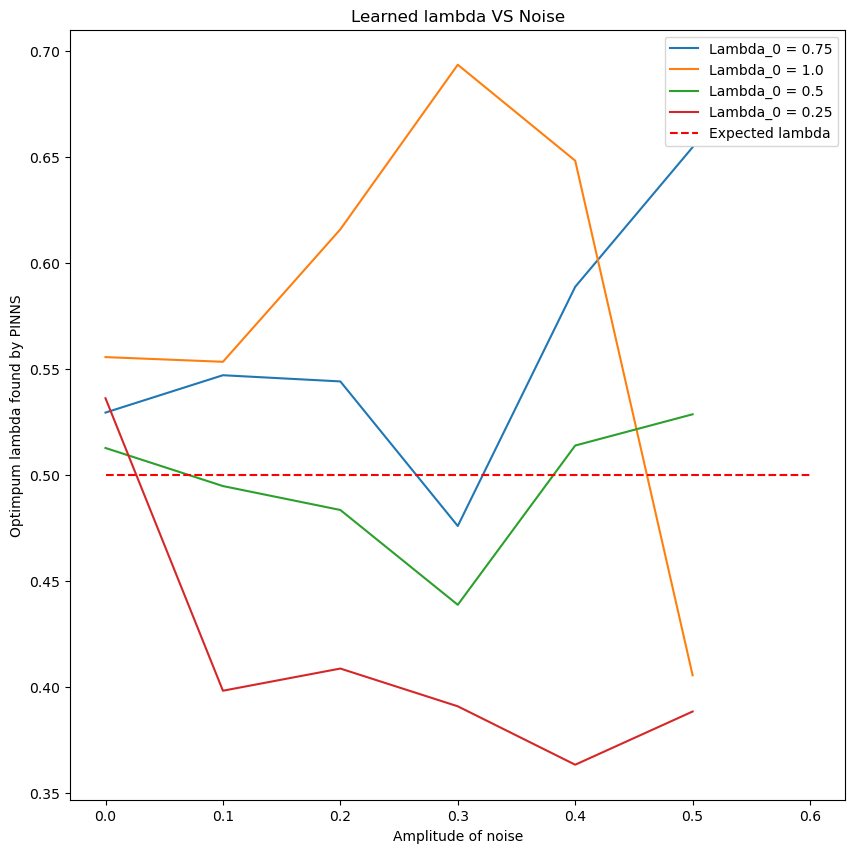

In [13]:
plt.figure(figsize=(10,10))
Lambda_0_vals = [0.75, 1., 0.5, 0.25]
for i in range(4):
    
    plt.plot(np.linspace(0,0.5,6), out[i], label = 'Lambda_0 = {}'.format(Lambda_0_vals[i]))

plt.hlines(0.5, 0, 0.6, color = 'r',linestyles = '--', label='Expected lambda')
plt.ylabel('Optimpum lambda found by PINNS')
plt.xlabel('Amplitude of noise')
plt.title('Learned lambda VS Noise')
plt.legend()

plt.show()

As the value of the noise amplitude increases, the value of $\lambda$ learned by PINNS diverges from the expected value.

### A system of linear PDEs

Consider the system \begin{cases}
v_t - \frac{1}{2} v_{xx} = \alpha v +\beta w,\\
w_t - \frac{1}{2} w_{xx} = \gamma v + \delta w.
\end{cases}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(t+1\right)e^{-t}, \\
v(1,t) = \left(t+2\right)e^{-t},\\
w(0,t) = \left(t+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(t+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}
The true parameters are
$$
\alpha^* =  -1, \quad \beta^* = 0, \quad \gamma^* = 1, \quad \delta^* =-2,
$$ and the exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + t + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + t + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

* Use noisy data to learn $\alpha, \beta, \gamma$ and $ \delta$. Try with different values of `eps`.

In [3]:
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + T + 1)*(np.exp(-T) - np.exp(-2*T))

def gen_data(eps=0.05):
    Z = np.random.uniform(0, 1, [10, 2])
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    noise = eps*np.random.uniform(-1, 1, [10, 2])

    return Z, np.stack([v.flatten(), w.flatten()], 1) + noise

In [5]:
def noisy_params(eps):
    alpha = tf.Variable(-0.5)
    beta  = tf.Variable(0.2)
    gamma = tf.Variable(1.2)
    delta = tf.Variable(-2.2)

    geom = dde.geometry.Rectangle((0,0), (1, 1))

    x_begin = 0; x_end = 1
    def boundary_bottom(z,on_boundary):  
        return dde.utils.isclose(z[1],x_begin)

    def boundary_top(z,on_boundary):  
        return dde.utils.isclose(z[1],x_end)

    def ic_begin(z,on_boundary):
        return dde.utils.isclose(z[0],0)


    a = 0.5

    bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
    bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

    bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
    bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

    points, Zs = gen_data(eps)
    obs_v = dde.icbc.PointSetBC(points, Zs[:,0:1],component = 0)
    obs_w = dde.icbc.PointSetBC(points, Zs[:,1:2],component = 1)

    bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w, obs_v, obs_w]


    def HEAT2_deepxde(z,y):
    
        v = y[:,0:1]
        w = y[:,1:2]
    
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        dv_dt = dde.grad.jacobian(v,z,0,0)
        dv_dx = dde.grad.jacobian(v,z,0,1)
        d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
        return [
            dv_dt - a * d2v_dx2 - alpha*v - beta*w,
            dw_dt - a * d2w_dx2 - gamma*v - delta*w
        ]

    def output_transform(z, q):
        v = q[:, 0:1]
        w = q[:, 1:2]
        t = z[:, 0:1]
        x = z[:, 1:2]
        return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


    data = dde.data.PDE(geom, HEAT2_deepxde,bcs, 
                            num_domain = 1000,
                            num_boundary = 6,
                            num_test=100,
                       anchors = points)
    
    net = dde.nn.FNN([2] + [60]*4 + [2], 'tanh', 'He uniform')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([alpha,beta,gamma,delta], period = 200)


    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks = [parameters])
    
    return parameters.value

In [6]:
alpha_vals = []
beta_vals = []
gamma_vals = []
delta_vals = []
for e in np.linspace(0,0.5,6):
    val = noisy_params(e)
    alpha_vals.append(val[0])
    beta_vals.append(val[1])
    gamma_vals.append(val[2])
    delta_vals.append(val[3])

Compiling model...
Building feed-forward neural network...
'build' took 0.103256 s

'compile' took 2.676728 s



2024-09-30 19:04:10.286009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [7.78e-01, 4.35e+00, 6.02e-01, 3.67e-01, 1.02e-01, 4.37e-02, 2.67e-01, 1.52e-01]    [7.34e-01, 4.29e+00, 6.02e-01, 3.67e-01, 1.02e-01, 4.37e-02, 2.67e-01, 1.52e-01]    []  
0 [-5.00e-01, 2.00e-01, 1.20e+00, -2.20e+00]
200 [-7.43e-01, 1.12e-01, 1.18e+00, -2.16e+00]
400 [-7.20e-01, 2.07e-01, 1.17e+00, -2.17e+00]
600 [-6.81e-01, 3.20e-01, 1.16e+00, -2.18e+00]
800 [-6.35e-01, 4.35e-01, 1.14e+00, -2.19e+00]
1000      [1.05e-02, 3.44e-04, 8.31e-03, 6.41e-05, 9.01e-03, 9.55e-04, 7.22e-02, 1.43e-02]    [8.34e-03, 2.52e-04, 8.31e-03, 6.41e-05, 9.01e-03, 9.55e-04, 7.22e-02, 1.43e-02]    []  
1000 [-6.01e-01, 5.37e-01, 1.12e+00, -2.20e+00]

Best model at step 1000:
  train loss: 1.16e-01
  test loss: 1.13e-01
  test metric: []

'train' took 36.231600 s

Compiling model...
Building 

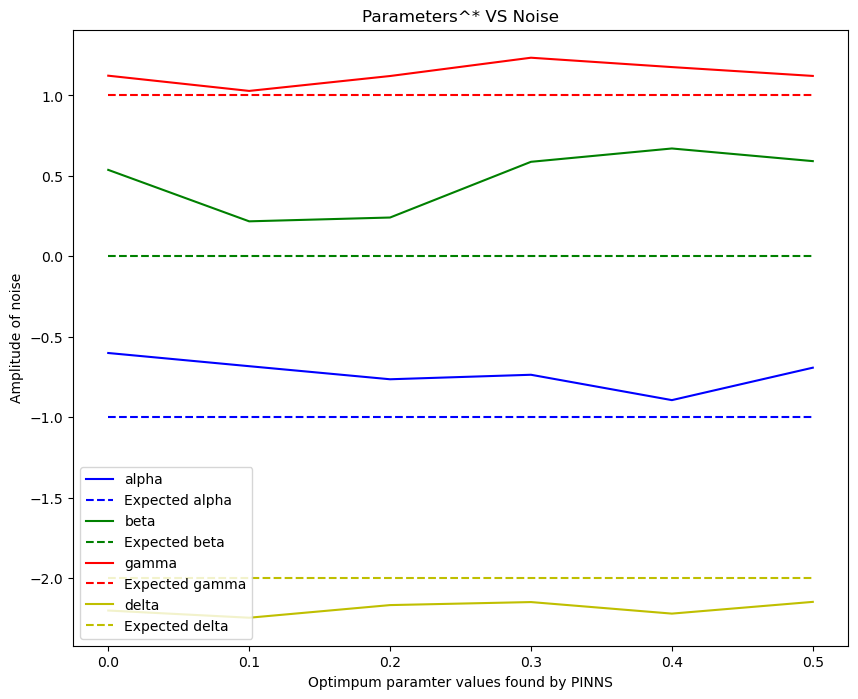

In [10]:
plt.figure(figsize=(10,8))

plt.plot(np.linspace(0,0.5,6), alpha_vals,'b', label = 'alpha')
plt.hlines(-1,0,0.5, color = 'b', linestyles = '--', label = 'Expected alpha')
plt.plot(np.linspace(0,0.5,6), beta_vals, 'g', label = 'beta')
plt.hlines(0,0,0.5, color = 'g', linestyles = '--', label = 'Expected beta')
plt.plot(np.linspace(0,0.5,6), gamma_vals,'r',  label = 'gamma')
plt.hlines(1,0,0.5, color = 'r', linestyles = '--', label = 'Expected gamma')
plt.plot(np.linspace(0,0.5,6), delta_vals,'y', label = 'delta')
plt.hlines(-2,0,0.5, color = 'y', linestyles = '--', label = 'Expected delta')

plt.xlabel('Optimpum paramter values found by PINNS')
plt.ylabel('Amplitude of noise')
plt.title('Parameters^* VS Noise')
plt.legend()

The value of the paramters learned by PINNS seems to be stable relative to the noise amplitude.

### Helmholtz equation

### Hamilton Jacobi equation

### Klein Gordon equation

### Schrödinger equation

In this example you will need to find the eigenstates of the Schrödinger equation of the quantum harmonic oscillator $$-\frac{\hbar^2}{2m}\frac{d^2 \psi}{dx^2} + \frac{1}{2}mx^2\omega^2 \psi = E\psi. $$

The eigenvalue $E_n = \omega (n + 1/2)$ has the normalized eigenstate

$$
\psi_n(x) = \frac{\omega^{1/4}}{\pi^{1/4} \sqrt{2^n n!}}  H_n\left(\sqrt{\omega} x\right)e^{-\frac{\omega x^2}{2}}.
$$

We will take $\hbar = m=1$. The initial condition is $(\psi(0), \psi'(0)) =(1,0)$ is $n$ is even and $(0,1)$ if $n$ is odd.

* Learn $E$ from data. Try with different values of `num_pts` and `eps`.

In [12]:
from numpy.polynomial.hermite import hermval

In [79]:
n = 5
omega = 0.5
E_star = (n + 0.5) * omega
coeff = [0]*n + [1]

def psi_sol(x):
    return (
        1 / (2**n * np.math.factorial(n))**0.5
        * (omega / np.pi)**(1/4)
        * np.exp(-omega * x**2 / 2)
        * hermval(omega**0.5 * x, coeff)
    )

def gen_data(num_pts=100, eps=0.1):
    X = np.random.uniform(0, 10, [num_pts, 1])
    noise = eps*np.random.uniform(-1, 1, [num_pts, 1])
    return X, psi_sol(X) + noise

In [76]:
#PINNS Solution

x_min = 0; x_max = 10
geom = dde.geometry.TimeDomain(x_min, x_max)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],x_min)

if n % 2 == 1:
    bc_psi_D = dde.icbc.DirichletBC (geom, lambda z: 0, ic_begin, component = 0)
    bc_psi_N = dde.icbc.NeumannBC(geom,lambda z: -1,ic_begin,component=0)
elif n % 2 == 0:
    bc_psi_D = dde.icbc.DirichletBC (geom, lambda z: 1, ic_begin, component = 0)
    bc_psi_N = dde.icbc.NeumannBC(geom,lambda z: 0,ic_begin,component=0)

def SH_ODE(eps=0.1, num_pts=100 , E_in = 5.):
    E = tf.Variable(E_in)
    
    points, Psis = gen_data(num_pts, eps)
    obs_psi = dde.icbc.PointSetBC(points, Psis, component = 0)

    bcs = [bc_psi_D, bc_psi_N, obs_psi]

    def SH_deepxde(z,y):
    
        psi = y[:, 0:1]
        x   = z[:, 0:1]
    
        dpsi_dx = dde.grad.jacobian(psi,z,0,0)
        d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
        return (-1/2)*d2psi_dx2  + (1/2)*((omega*x)**2)*psi - E*psi



    data = dde.data.PDE(geom, SH_deepxde,bcs, 
                        num_domain = 1500,
                        num_boundary = 2,
                        num_test = 100,
                        anchors = points
                       )
    
    net = dde.nn.FNN([1] + [60]*4 + [1], 'tanh', 'Glorot uniform')
    parameters = dde.callbacks.VariableValue([E], period = 200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = 2000, callbacks = [parameters])
    
    return parameters.value

In [80]:
out = []
nums = [100,150,200]
nois = [0.1, 0.3, 0.5, 0.7]
for i in range(3):
    Es = []
    for eps in nois:
        Es.append(SH_ODE(eps=eps, num_pts=nums[i] , E_in = 2.5)[0])
    out.append(Es)


Compiling model...
Building feed-forward neural network...
'build' took 0.247248 s

'compile' took 3.534623 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.41e-01, 1.00e+00, 4.06e-05, 5.81e-02]    [5.22e-01, 1.00e+00, 4.06e-05, 5.81e-02]    []  
0 [2.50e+00]
200 [2.57e+00]
400 [2.53e+00]
600 [2.48e+00]
800 [2.43e+00]
1000      [3.22e-02, 4.94e-03, 8.61e-05, 3.82e-02]    [3.21e-02, 4.94e-03, 8.61e-05, 3.82e-02]    []  
1000 [2.36e+00]
1200 [2.28e+00]
1400 [2.22e+00]
1600 [2.16e+00]
1800 [2.13e+00]
2000      [2.55e-02, 3.54e-03, 3.69e-05, 3.50e-02]    [2.58e-02, 3.54e-03, 3.69e-05, 3.50e-02]    []  
2000 [2.09e+00]

Best model at step 2000:
  train loss: 6.41e-02
  test loss: 6.43e-02
  test metric: []

'train' took 82.109956 s

Compiling model...
Building feed-forward neural network...
'build' took 0.198978 s

'compile' took 5.007013 s

Training model...

Step      Train loss                

2000 [2.16e+00]

Best model at step 2000:
  train loss: 1.04e-01
  test loss: 1.05e-01
  test metric: []

'train' took 105.054256 s

Compiling model...
Building feed-forward neural network...
'build' took 0.389193 s

'compile' took 7.199164 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.94e+00, 1.00e+00, 7.04e-02, 3.77e-01]    [3.90e+00, 1.00e+00, 7.04e-02, 3.77e-01]    []  
0 [2.50e+00]
200 [2.56e+00]
400 [2.51e+00]
600 [2.45e+00]
800 [2.38e+00]
1000      [3.62e-02, 6.76e-03, 4.07e-05, 1.19e-01]    [3.56e-02, 6.76e-03, 4.07e-05, 1.19e-01]    []  
1000 [2.29e+00]
1200 [2.20e+00]
1400 [2.12e+00]
1600 [2.06e+00]
1800 [2.00e+00]
2000      [3.46e-02, 5.02e-03, 5.53e-06, 1.13e-01]    [3.42e-02, 5.02e-03, 5.53e-06, 1.13e-01]    []  
2000 [1.95e+00]

Best model at step 2000:
  train loss: 1.52e-01
  test loss: 1.52e-01
  test metric: []

'train' took 96.807777 s

Compiling model...
Building feed-

In the follwoing we plot the results for $n=2$ and $n=5$. Number of observations are [100,150,200], and value for noise amplitudes are [0.1, 0.3, 0.5, 0.7]

For $n=5$ the values of E learned by the NN are less sensitive to noise amplitudes, but hteir value is very different with the expected value of $E^*$.

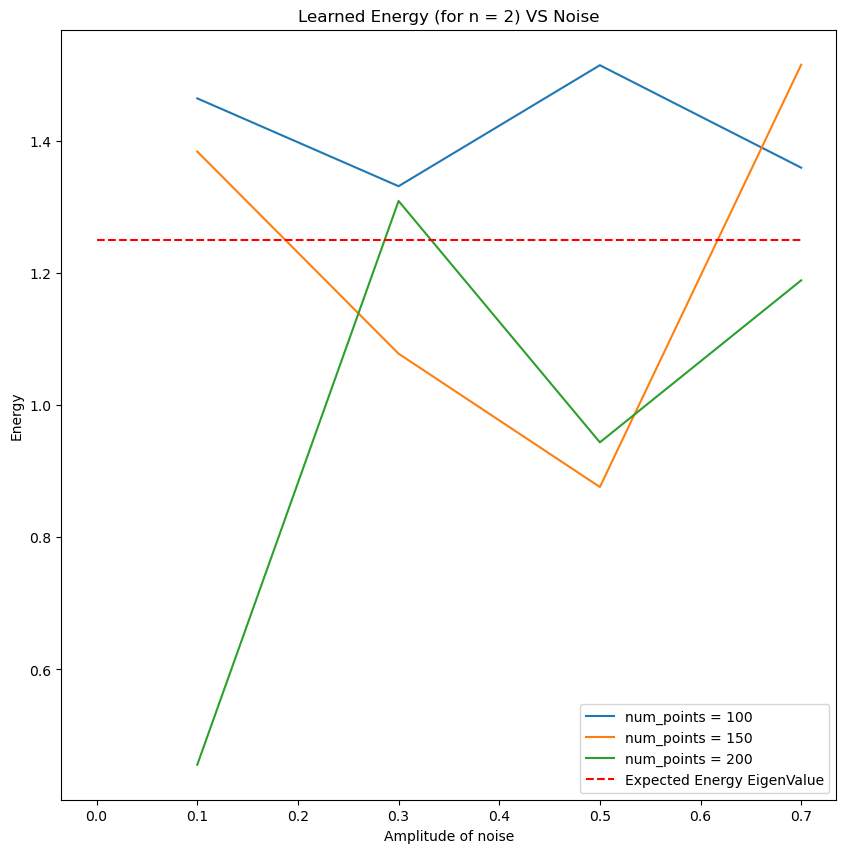

In [78]:
plt.figure(figsize=(10,10))
nums = [100,150,200]
for i in range(3):
    
    plt.plot(nois, out[i], label = 'num_points = {}'.format(nums[i]))

plt.hlines(E_star, 0, 0.7, color = 'r',linestyles = '--', label='Expected Energy EigenValue')
plt.ylabel('Energy')
plt.xlabel('Amplitude of noise')
plt.title('Learned Energy (for n = {}) VS Noise'.format(2))
plt.legend()

plt.show()

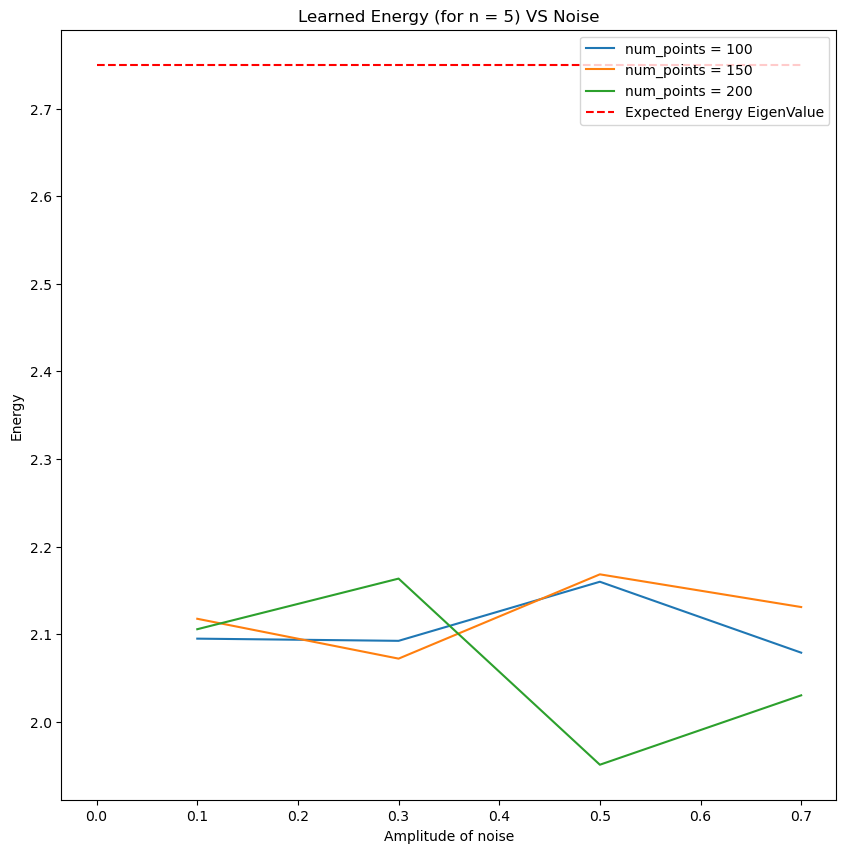

In [81]:
plt.figure(figsize=(10,10))
nums = [100,150,200]
for i in range(3):
    
    plt.plot(nois, out[i], label = 'num_points = {}'.format(nums[i]))

plt.hlines(E_star, 0, 0.7, color = 'r',linestyles = '--', label='Expected Energy EigenValue')
plt.ylabel('Energy')
plt.xlabel('Amplitude of noise')
plt.title('Learned Energy (for n = {}) VS Noise'.format(5))
plt.legend()

plt.show()